In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [2]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [3]:
# TODO: Logic about 'max_epochs'. 10 for fda, -1 for fedopt

In [4]:
# List to store all DataFrames
dfs = []

folder_path = '../results/round_metrics'

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file)
        # Load the CSV file into a DataFrame and append it to the list
        dfs.append(pd.read_csv(file_path, index_col=0))

In [5]:
df =  pd.concat(dfs, ignore_index=True)

In [6]:
df['accuracy'] = 100 * df['accuracy'].round(4)
df['accuracy_m'] = 100 * df['accuracy_m'].round(4)
df['accuracy_mm'] = 100 * df['accuracy_mm'].round(4)
df['f1'] = 100 * df['f1'].round(4)
df['matthews_correlation'] = 100 * df['matthews_correlation'].round(4)

In [7]:
df['server_opt_lr_log10'] = np.log10(df['server_opt_lr']).round(1)
df['client_opt_lr_log10'] = np.log10(df['client_opt_lr']).round(1)

In [8]:
df_fedopt = df[~df['fda']].copy()

In [9]:
df_fedopt.loc[:, 'E'] = df_fedopt['local_epochs'].apply(lambda x: int(x))

In [10]:
df_fdaopt = df[df['fda']].copy()

In [11]:
df_fdaopt.loc[:, 'E'] = ((df_fdaopt['max_epochs'] - 8) / 2).apply(lambda x: int(x))

In [12]:
best_performing = {
    ('MRPC', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('MRPC', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    ('MRPC', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    
    ('RTE', 'FedAdam'): {'server_opt_lr_log10': -5, 'client_opt_lr_log10': -5},
    ('RTE', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('RTE', 'FedAvgM'): {'server_opt_lr_log10': -1, 'client_opt_lr_log10': -3},
    ('RTE', 'FedAdamW'): {'server_opt_lr_log10': -5, 'client_opt_lr_log10': -5},
    ('RTE', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    
    ('CoLA', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    ('CoLA', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('CoLA', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -5},
    ('CoLA', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('CoLA', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    
    ('SST-2', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('SST-2', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    
    ('QNLI', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
}

In [13]:
best_performing_deberta = {
    ('MNLI', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -2},
    ('MNLI', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -2},
    ('MNLI', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MNLI', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('MNLI', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -2},
}

In [14]:
def filter_unique_test(df, checkpoint, ds_path, ds_name, alpha, batch_size, num_clients, clients_per_round, fda):
    return df[
        (df['checkpoint'] == checkpoint) &
        (df['ds_path'] == ds_path) &
        (df['ds_name'] == ds_name) &
        (df['alpha'] == alpha) &
        (df['batch_size'] == batch_size) &
        (df['num_clients'] == num_clients) &
        (df['clients_per_round'] == clients_per_round) &
        (df['fda'] == fda)
    ]

In [15]:
def filter_opt(df, algo):
    if algo == 'FedAdam':
        return df[
            (df['server_opt_name'] == 'Adam') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvg':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'].isna())
        ]
    if algo =='FedYogi':
        return df[
            (df['server_opt_name'] == 'Yogi') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvgM':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'] == 0.9)
        ]
    if algo == 'FedAdaGrad':
        return df[
            (df['server_opt_name'] == 'Adagrad') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAdamW':
        return df[
            (df['server_opt_name'] == 'AdamW') &
            (df['client_opt_name'] == 'SGD')
        ]

In [16]:
def learning_rate_grid_max(df, algo, ds_name, metric):
    
    df_algo = filter_opt(df, algo)
    
    df_algo = df_algo[df_algo['E'] == 1]
    
    column_metric = metric.lower().replace(' ', '_')
    # Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
    df_algo_round = (
        df_algo.sort_values([column_metric, 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
        .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
        .first()  # Select the first row in each group
    )
    #print(df_algo_round)
    
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values=column_metric)

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/max_{ds_name}_{algo}.pdf')

    # Create the plot
    #plt.figure(figsize=(7, 7))
    plt.figure(figsize=(6.4, 5.5))
    """ For fdaavg
    plt.figure(figsize=(3.2, 7))
    """
    
    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        #vmin=30,
        #vmax=90
    )
    
    
    
    """ For fdaavg
    plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
    # Reduce whitespace around the plot
    plt.subplots_adjust(left=0.1, right=0.65)
    """
    
    plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.15)
    


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label(metric)

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    #plt.title(f'{ds_name}, {algo}')
    plt.title(f'{algo}', fontsize=26)
    
    """for fdaavg
    plt.xticks([])
    """
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [17]:
def fda_name(fed_opt):
    if fed_opt == 'FedAdam':
        return 'FDA-Adam'
    if fed_opt == 'FedAvg':
        return 'FDA-SGD'
    if fed_opt == 'FedAvgM':
        return 'FDA-SGDM'
    if fed_opt == 'FedAdaGrad':
        return 'FDA-Adagrad'
    if fed_opt == 'FedAdamW':
        return 'FDA-AdamW'
    
    if fed_opt == 'FedYogi':
        return 'FDA-Yogi'

In [18]:
def plot_all_variance(df, ds_name, every=10):
    pdf = PdfPages(f'plots/var_{ds_name}.pdf')
    
    # Create the plot
    #plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 3))
    
    markers = ['o', 's', 'D', '^', 'v']
    
    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        df_alg = filter_opt(df, alg)
        df_alg = df_alg[df_alg['E'] == 1]
        df_alg = df_alg[
            (df_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
    
        plt.plot(df_alg['round'], df_alg['variance'], marker=markers[i], markersize=8, markevery=every, linestyle='-', label=alg)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Model Variance')

    plt.yscale('log')

    # Add a title
    #plt.title(algo)
    #plt.tight_layout()
    
    plt.subplots_adjust(top=0.95, bottom=0.14)
    
    plt.yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

    # Add a legend
    plt.legend(ncol=3, fontsize=13)
    
    #plt.show()

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [19]:
def plot_all_variance_fda(df, ds_name, every=10):
    pdf = PdfPages(f'plots/var_fda_{ds_name}.pdf')
    
    # Create the plot
    #plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 5))
    
    markers = ['o', 's', 'D', '^', 'v']
    
    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        df_alg = filter_opt(df, alg)
        df_alg = df_alg[df_alg['E'] == 1]
        df_alg = df_alg[
            (df_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        
        fda_alg = alg.replace('Fed', 'FDA-')
        fda_alg = fda_alg.replace('AvgM', 'SGDM')
        fda_alg = fda_alg.replace('Avg', 'SGD')
    
        plt.plot(df_alg['round'], df_alg['variance'], marker=markers[i], markevery=every, linestyle='-', label=fda_alg)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Model Variance')

    plt.yscale('log')

    # Add a title
    #plt.title(algo)
    #plt.tight_layout()
    
    plt.subplots_adjust(top=0.95, bottom=0.14)

    # Add a legend
    plt.legend(ncol=2)
    
    plt.yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [20]:
def training_loss(df_fda, df_fed, ds_name, every=10):

    markers = ['o', 's', 'D', '^', 'v']

    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        # Create the plot
        #plt.figure(figsize=(10, 6))
        plt.figure(figsize=(10, 6))

        df_alg_fed = filter_opt(df_fed, alg)
        df_alg_fda = filter_opt(df_fda, alg)

        df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
        df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]
        
        df_alg_fed = df_alg_fed[
            (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        
        df_alg_fda = df_alg_fda[
            (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        

        #plt.plot(df_alg_fed['round'], df_alg_fed['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{alg} Validation Loss', color='red')
        plt.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, linestyle='-', label=alg, color='red')
        
        fda_alg = alg.replace('Fed', 'FDA-')
        fda_alg = fda_alg.replace('AvgM', 'SGDM')
        fda_alg = fda_alg.replace('Avg', 'SGD')
        #plt.plot(df_alg_fda['round'], df_alg_fda['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{fda_alg} Validation Loss', color='green')
        plt.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, linestyle='-', label=fda_alg, color='green')

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.6)

        # Label the axes
        plt.xlabel('Round')
        plt.ylabel('Training Loss')

        plt.yscale('log')
        
        """ For fdaavg
        plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
        # Reduce whitespace around the plot
        plt.subplots_adjust(left=0.1, right=0.65)
        """
        #plt.gca().set_aspect(50)

        # Add a title
        #plt.title(algo)
        #plt.tight_layout()

        #plt.subplots_adjust(top=0.95, bottom=0.14)

        # Add a legend
        plt.legend()
        plt.show()
        plt.close()

In [21]:
def accuracy(df_fda, df_fed, ds_name, every=10):

    markers = ['o', 's', 'D', '^', 'v']

    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        # Create the plot
        #plt.figure(figsize=(10, 6))
        plt.figure(figsize=(10, 6))

        df_alg_fed = filter_opt(df_fed, alg)
        df_alg_fda = filter_opt(df_fda, alg)

        df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
        df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]
        
        df_alg_fed = df_alg_fed[
            (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        
        df_alg_fda = df_alg_fda[
            (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        

        #plt.plot(df_alg_fed['round'], df_alg_fed['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{alg} Validation Loss', color='red')
        plt.plot(df_alg_fed['round'], df_alg_fed['accuracy'], marker='^', markevery=every, linestyle='-', label=alg, color='red')
        
        fda_alg = alg.replace('Fed', 'FDA-')
        fda_alg = fda_alg.replace('AvgM', 'SGDM')
        fda_alg = fda_alg.replace('Avg', 'SGD')
        #plt.plot(df_alg_fda['round'], df_alg_fda['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{fda_alg} Validation Loss', color='green')
        plt.plot(df_alg_fda['round'], df_alg_fda['accuracy'], marker='s', markevery=every, linestyle='-', label=fda_alg, color='green')

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.6)

        # Label the axes
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        
        """ For fdaavg
        plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
        # Reduce whitespace around the plot
        plt.subplots_adjust(left=0.1, right=0.65)
        """
        #plt.gca().set_aspect(50)

        # Add a title
        #plt.title(algo)
        #plt.tight_layout()

        #plt.subplots_adjust(top=0.95, bottom=0.14)

        # Add a legend
        plt.legend()
        plt.show()
        plt.close()

In [22]:
df_fedopt_tmp = df_fedopt.copy()
df_fdaopt_tmp = df_fdaopt.copy() 

# ROBERTA

In [34]:
df_fedopt = df_fedopt_tmp[df_fedopt_tmp['checkpoint'] == 'roberta-base']
df_fdaopt = df_fdaopt_tmp[df_fdaopt_tmp['checkpoint'] == 'roberta-base']

## MRPC

clients = 10, per round = 10, max rounds = 100

In [21]:
best_accuracy = 90.2

In [22]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 100]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 100]

In [23]:
max(df_fed_opt['accuracy'])

90.2

In [24]:
max(df_fda_opt['accuracy'])

89.46

### Best learning rate for FedOpt

In [26]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'MRPC', 'Accuracy')

In [27]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'MRPC', 'Accuracy',)

In [28]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'MRPC', 'Accuracy',)

In [29]:
#learning_rate_grid(df_mrpc, 'FedAdaGrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'MRPC', 'Accuracy',)

In [30]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'MRPC', 'Accuracy',)

### Paper FedAvg

In [468]:
ds_name = 'MRPC'
metric = 'Accuracy'
algo = 'FedAvg'
    
df_algo = filter_opt(df_fed_opt, algo)

df_algo = df_algo[df_algo['local_epochs'] == 1]

column_metric = metric.lower().replace(' ', '_')
# Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
df_algo_round = (
    df_algo.sort_values([column_metric, 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
    .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
    .first()  # Select the first row in each group
)
#print(df_algo_round)


# Pivot the DataFrame for easier plotting
pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values=column_metric)

# Extract unique learning rates and accuracy values
client_opt_lr = pivot_table.index.astype(float)
server_opt_lr = pivot_table.columns.astype(float)
accuracy = pivot_table.values



# Compute grid edges (midpoints)
client_opt_lr_edges = []
server_opt_lr_edges = []

for axes_val in client_opt_lr:
    client_opt_lr_edges.append(axes_val - 0.5)
    client_opt_lr_edges.append(axes_val + 0.5)

for axes_val in server_opt_lr:
    server_opt_lr_edges.append(axes_val - 0.5)
    server_opt_lr_edges.append(axes_val + 0.5)

client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))

pdf = PdfPages(f'plots/max_{ds_name}_{algo}.pdf')

# Create the plot
#plt.figure(figsize=(7, 7))
plt.figure(figsize=(2.7, 5.5))
""" For fdaavg
plt.figure(figsize=(3.2, 7))
"""

# Add accuracy numbers inside the boxes
for i in range(len(client_opt_lr)):
    for j in range(len(server_opt_lr)):
        plt.text(
            server_opt_lr[j],  # X-coordinate (server learning rate)
            client_opt_lr[i],  # Y-coordinate (client learning rate)
            f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
            ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
        )

# Use pcolormesh with the adjusted edges
mesh = plt.pcolormesh(
    server_opt_lr_edges,  # Server learning rate edges
    client_opt_lr_edges,  # Client learning rate edges
    accuracy,             # Accuracy values
    cmap='Blues',
    #vmin=30,
    #vmax=90
)



""" For fdaavg
plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
# Reduce whitespace around the plot
plt.subplots_adjust(left=0.1, right=0.65)
"""

plt.subplots_adjust(left=0.35, right=0.7, top=0.92, bottom=0.15)



# Add color bar
cbar = plt.colorbar(mesh)
cbar.set_label(metric)

# Label the axes
#plt.xlabel('Server Learning Rate ($\log_{10}$)')
plt.ylabel('Client Learning Rate ($\log_{10}$)')
#plt.title(f'{ds_name}, {algo}')
plt.title(f'{algo}', fontsize=26)


plt.xticks([])

plt.xticks(server_opt_lr)
plt.yticks(client_opt_lr)

# Show the plot
#plt.show()

pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()

### Variance

In [96]:
plot_all_variance(df_fed_opt, 'MRPC')

In [65]:
plot_all_variance_fda(df_fda_opt, 'MRPC')

In [33]:
plt.rcParams['legend.fontsize'] = 16

### Training Loss

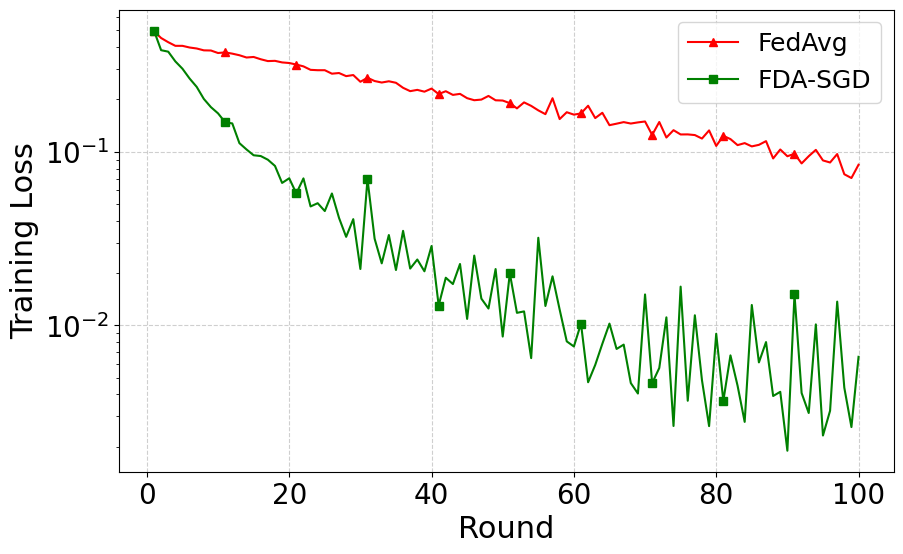

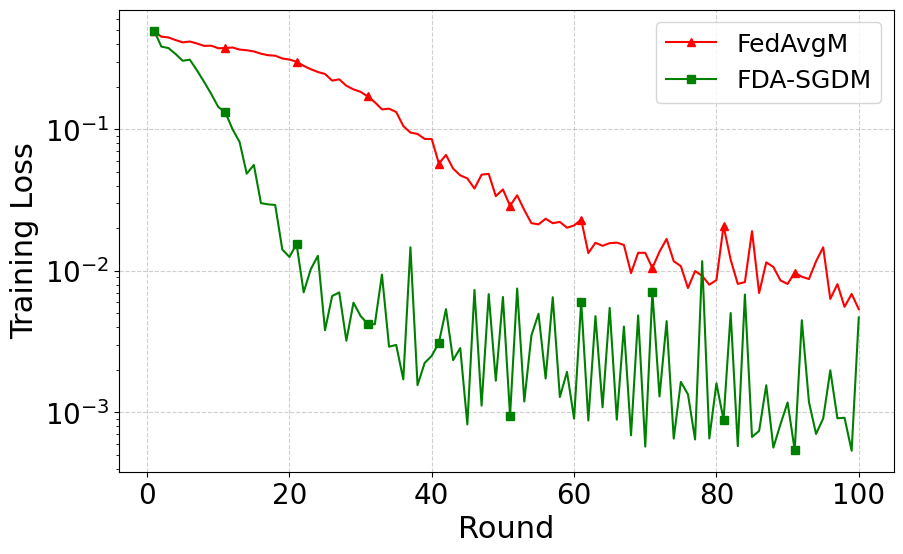

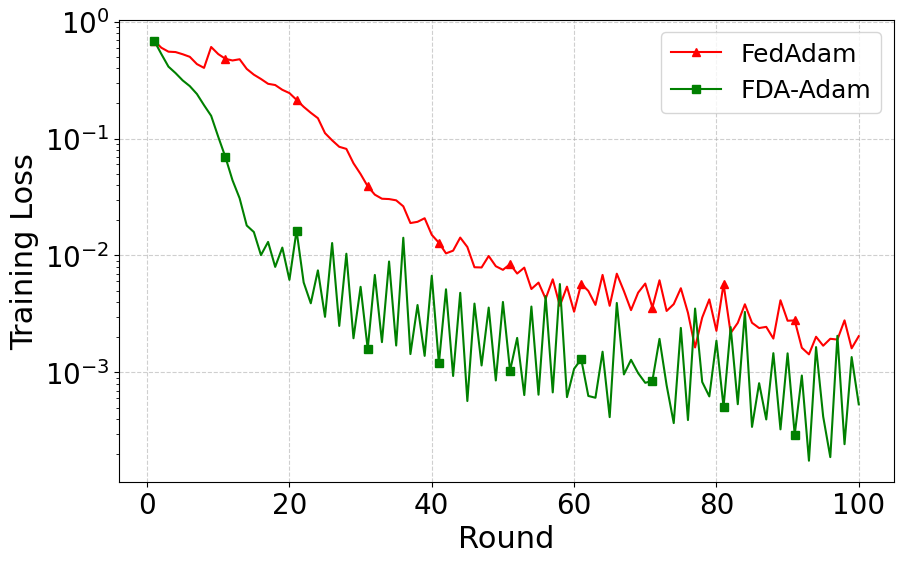

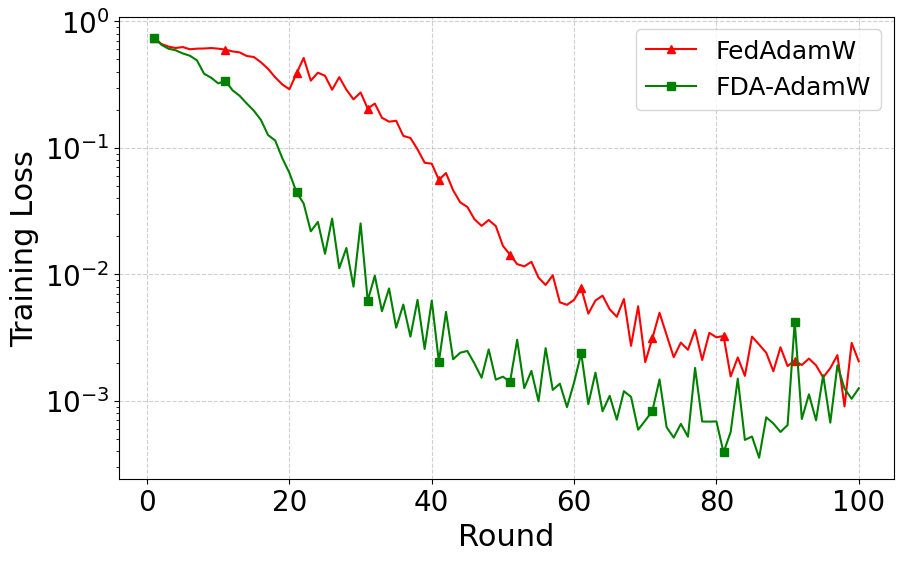

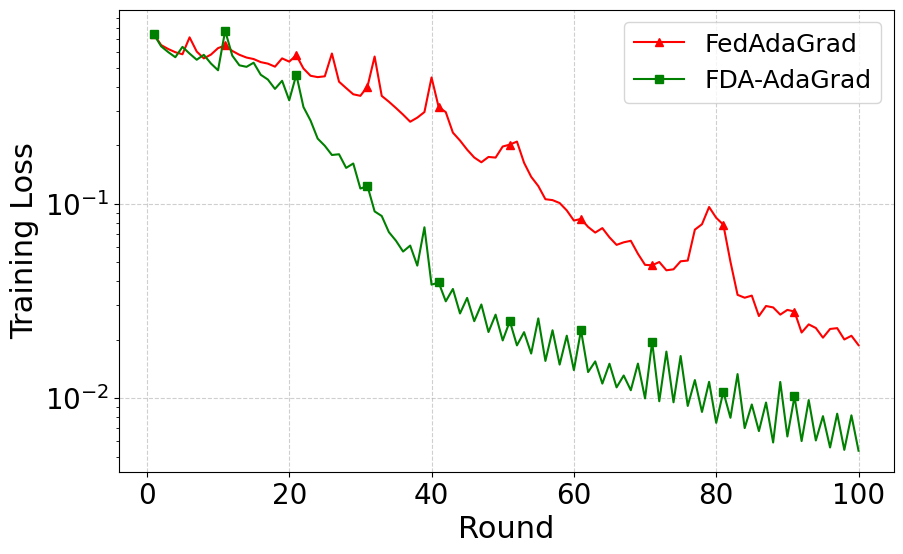

In [67]:
training_loss(df_fda_opt, df_fed_opt, 'MRPC', every=10)

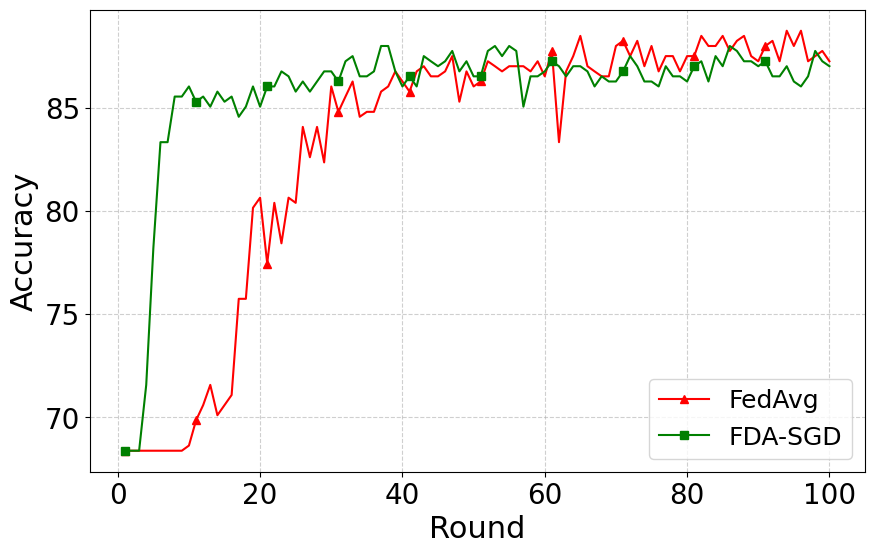

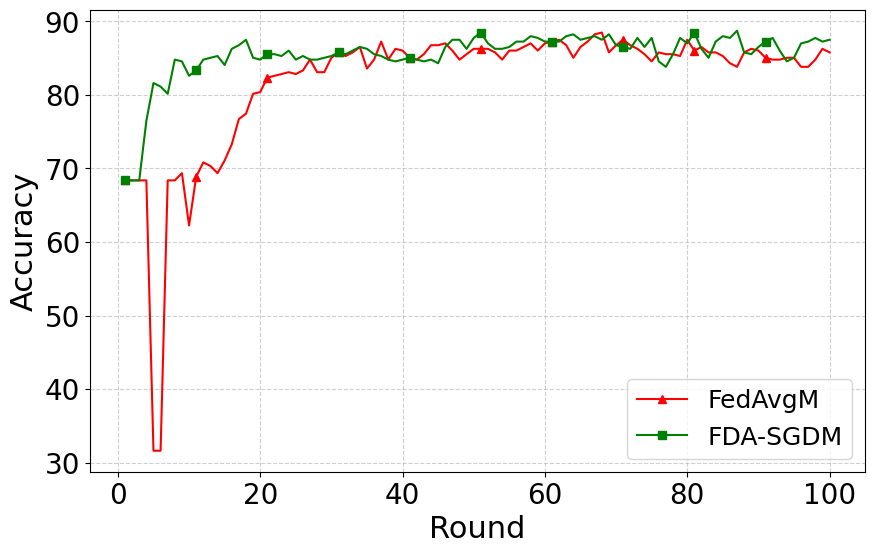

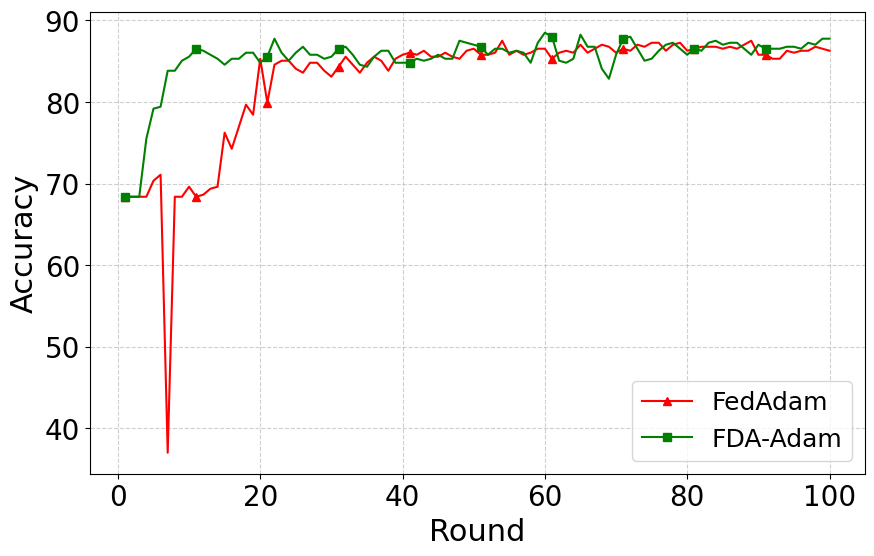

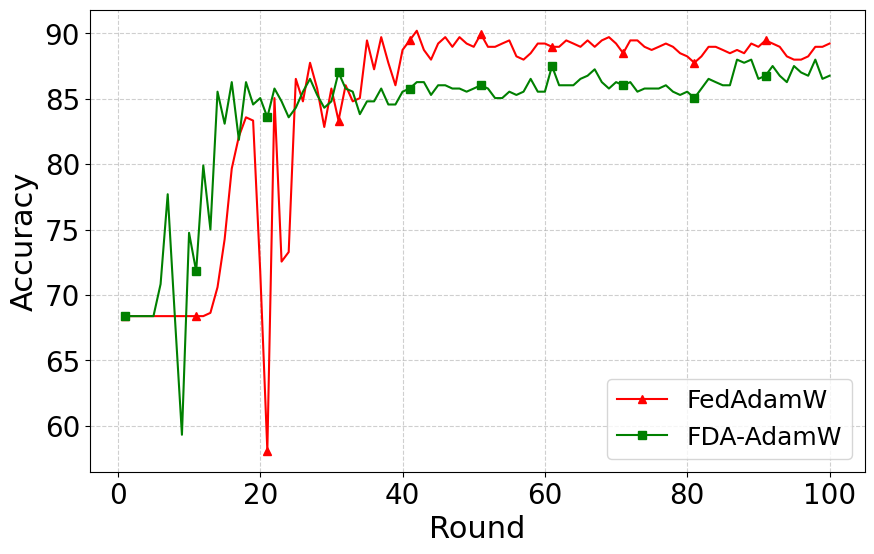

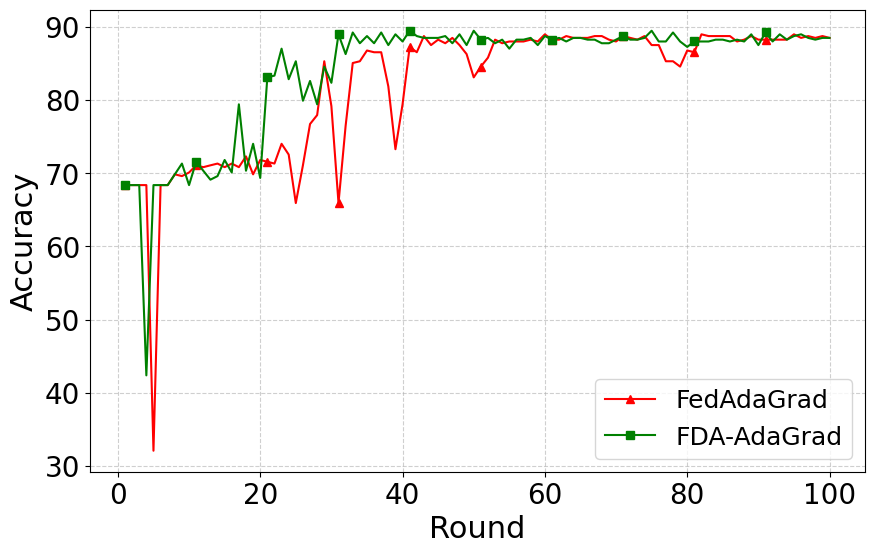

In [68]:
accuracy(df_fda_opt, df_fed_opt, 'MRPC', every=10)

### Paper training loss

In [143]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'MRPC'
every = 20
markersize=8
    
pdf = PdfPages(f'plots/train_loss_{ds_name}.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
#fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 10), sharex=True, sharey=True)


# --------------- FedAvg ------------------------------------
i = 0
alg = 'FedAvg'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

ax.set_title('MRPC', fontsize=26)

# --------------- FedAvgM ------------------------------------
i = 1
alg = 'FedAvgM'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every,markersize=markersize,  linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=13)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')


# --------------- FedAdam ------------------------------------
i = 2
alg = 'FedAdam'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdamW ------------------------------------
i = 3
alg = 'FedAdamW'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=13)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdaGrad ------------------------------------
i = 4
alg = 'FedAdaGrad'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

plt.subplots_adjust(left=0.25, top=0.96, bottom=0.07, right=0.95)



# Label the axes
plt.xlabel('Round')
#plt.ylabel('Training Loss')



pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()
#plt.show()

### FDA vs Fed-Opt

In [42]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [43]:
percentages = [0.85, 0.9, 0.95]

In [45]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

Algorithm 0.85 0.9 0.95
0       FedAvg (e = 1)   19  26   30
1              FDA-SGD    5   6   10
2                    #    #   #    #
3      FedAvgM (e = 1)   17  21   31
4             FDA-SGDM    5   5   16
5                    #    #   #    #
6      FedAdam (e = 1)   17  20   40
7             FDA-Adam    5   7   11
8                    #    #   #    #
9     FedAdamW (e = 1)   16  17   25
10           FDA-AdamW    7  14   16
11                   #    #   #    #
12  FedAdaGrad (e = 1)   27  29   35
13         FDA-Adagrad   17  21   23
14                   #    #   #    #

In [135]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [136]:
speedup_tab

Information      0.85       0.9      0.95
0      FDA-SGD Speedup       3.8  4.333333       3.0
1     FDA-SGDM Speedup       3.4       4.2    1.9375
2     FDA-Adam Speedup       3.4  2.857143  3.636364
3    FDA-AdamW Speedup  2.285714  1.214286    1.5625
4  FDA-Adagrad Speedup  1.588235  1.380952  1.521739
5      Average Speedup   2.89479  2.797143  2.331621

### FDA vs Fed-Opt for 95% accuracy with varying E

In [27]:
for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:
    
    plt.figure(figsize=(5, 3.5))
    
    pdf = PdfPages(f'plots/MRPC_{alg}_E.pdf')

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]
    
    fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_R = []
    
    fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_R = []
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:
        
        df_e = df_fed_alg[df_fed_alg['E'] == E]
        
        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * 0.95]
        
        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])
    
    for E in fdaopt_E:
        
        df_e = df_fda_alg[df_fda_alg['E'] == E]
        
        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * 0.95]
        
        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])
    
    
    #plt.plot(fedopt_E, fedopt_R, marker='^', linestyle='-', label=alg, color='red')
    
    fda_alg = alg.replace('Fed', 'FDA-')
    fda_alg = fda_alg.replace('AvgM', 'SGDM')
    fda_alg = fda_alg.replace('Avg', 'SGD')
    #plt.plot(fdaopt_E, fdaopt_R, marker='s', linestyle='-', label=fda_alg, color='green')
    
    
    fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]

    plt.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    plt.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')
    
    if fedopt_interpolated_indices:
        plt.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    
    plt.ylabel('Rounds')
    plt.xlabel('Local Epoch (E)')
    plt.xticks(fdaopt_E)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim([0, 100])
    plt.legend()
    
    plt.subplots_adjust(left=0.2, top=0.96, bottom=0.25, right=0.97)
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

### Paper Varying E

In [31]:
total_fedopt = 0
total_fdaopt = 0

In [32]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'MRPC'
close = 0.95
    
pdf = PdfPages(f'plots/{ds_name}_E.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 11), sharex=True)


# --------------- FedAvg ------------------------------------

for i, (alg, fda_alg) in enumerate(zip(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad'], ['FDA-SGD', 'FDA-SGDM', 'FDA-Adam', 'FDA-AdamW', 'FDA-AdaGrad'])):

    ax = axes[i]

    df_fed_alg = filter_opt(df_fed, alg)
    df_fda_alg = filter_opt(df_fda, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    #fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_E = [1, 3, 5, 15, 20]
    fdaopt_R = []

    #fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_E = [1, 3, 5, 15, 20] 
    fedopt_R = []

    #print(df_fed_alg['E'].unique())

    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:

        df_e = df_fed_alg[df_fed_alg['E'] == E]

        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])
            
            total_fedopt += def_fed_alg_best.iloc[0]['round']

    for E in fdaopt_E:

        df_e = df_fda_alg[df_fda_alg['E'] == E]

        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])
            
            total_fdaopt += def_fda_alg_best.iloc[0]['round']

    #fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit=1, method='linear', limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]
    
    # Create interpolation function using only valid values
    interp_func = interp1d(fedopt_E_clean, fedopt_R_clean, kind='linear', fill_value='extrapolate')
    # Perform interpolation for all x values
    fedopt_R_interpolated = interp_func(fedopt_E)

    ax.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    ax.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')

    if fedopt_interpolated_indices:
        ax.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    ax.set_ylabel('Rounds')
    ax.set_xticks(fdaopt_E)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    #ax.set_ylim([0, 100])
    if alg == 'FedAvg':
        ax.legend(loc='upper left')
        ax.set_ylim([1, 99])
    if alg == 'FedAvgM':
        ax.set_ylim([1, 80])
        ax.legend(loc=[0.1, 0.3], fontsize=16.5)
    if alg == 'FedAdam':
        #ax.legend(loc='upper center')
        ax.set_ylim([1, 60])
    if alg == 'FedAdamW':
        #ax.legend(loc='upper center')
        ax.legend(fontsize=15)
        ax.set_ylim([5, 99])
    if alg == 'FedAdaGrad':
        #ax.legend(loc='upper center')
        ax.set_ylim([15, 85])
        ax.legend(fontsize=15)

    if i == 0:
        ax.set_title(ds_name, fontsize=26)



plt.xlabel('Local Epochs (E)')


#plt.show()
plt.subplots_adjust(left=0.2, top=0.95, bottom=0.07, right=0.95)


pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()
#plt.show()

In [33]:
total_fedopt

601

In [34]:
total_fdaopt

431

## RTE

clients = 10, per round = 5, max rounds = 250

In [42]:
best_accuracy = 78.7

In [43]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='rte', alpha=1., batch_size=8, num_clients=10, clients_per_round=5, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='rte', alpha=1., batch_size=8, num_clients=10, clients_per_round=5, fda=True
)

In [44]:
max(df_fed_opt['accuracy'])

81.23

In [45]:
max(df_fda_opt['accuracy'])

81.23

### Training Loss

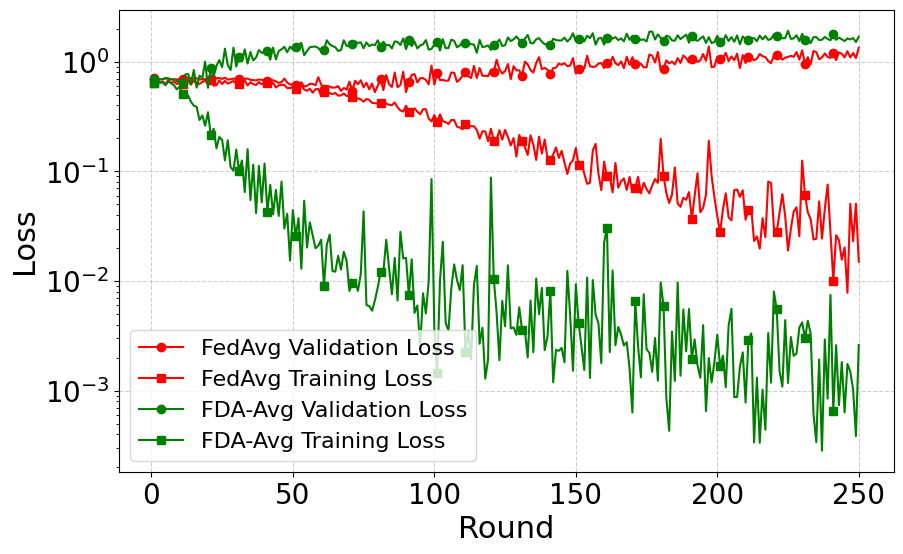

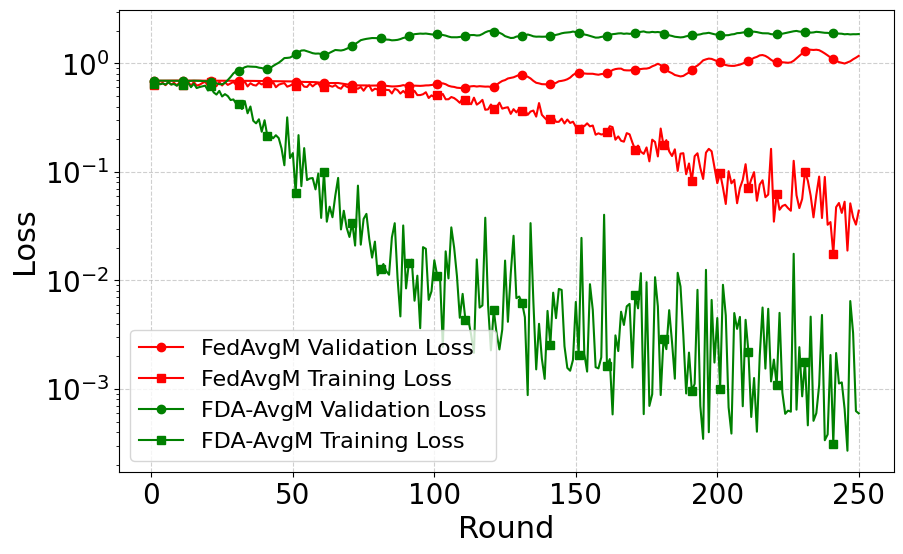

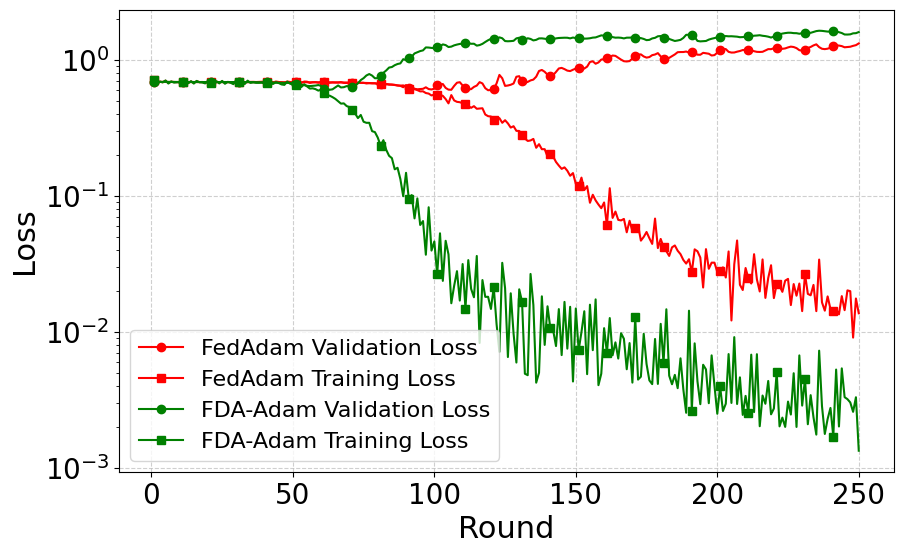

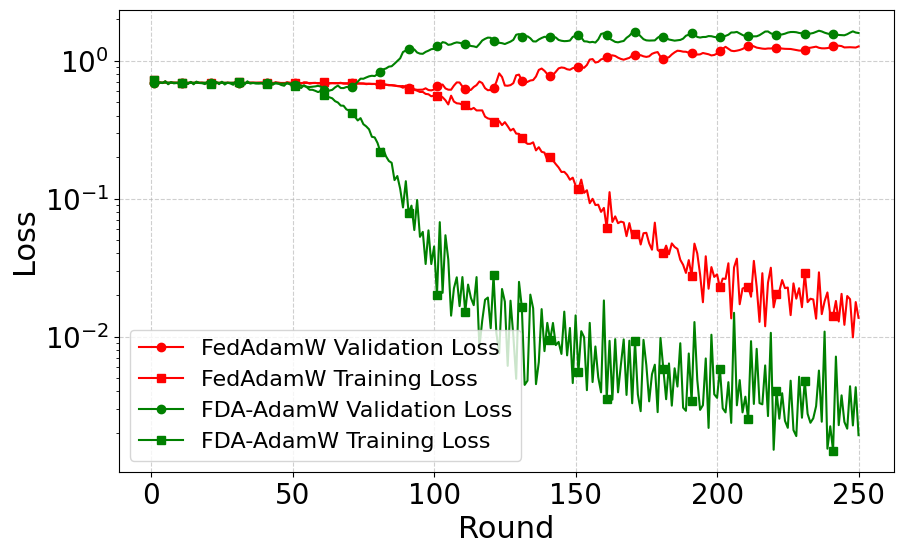

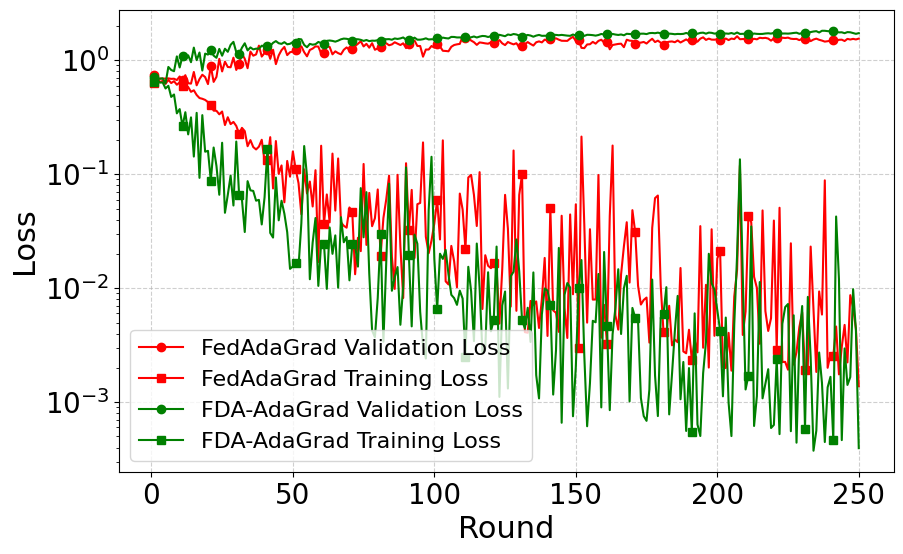

In [222]:
training_loss(df_fda_opt, df_fed_opt, 'RTE', every=10)

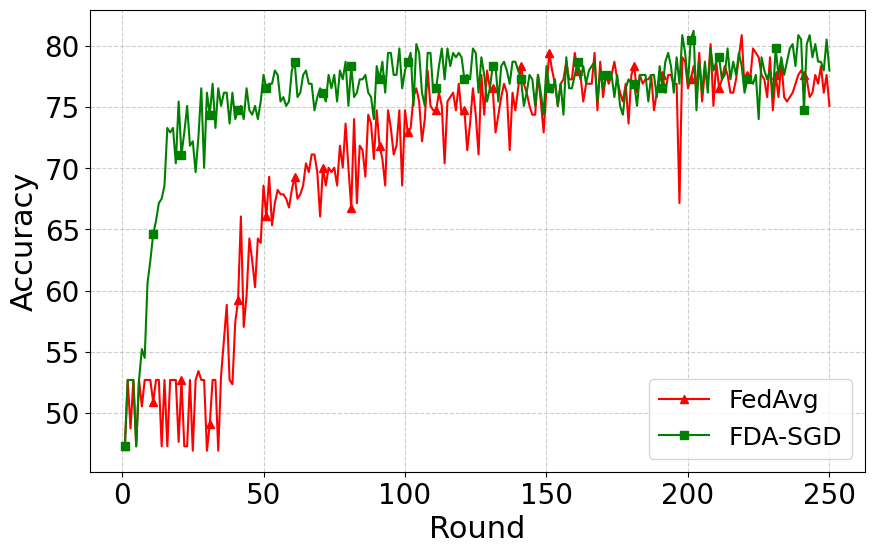

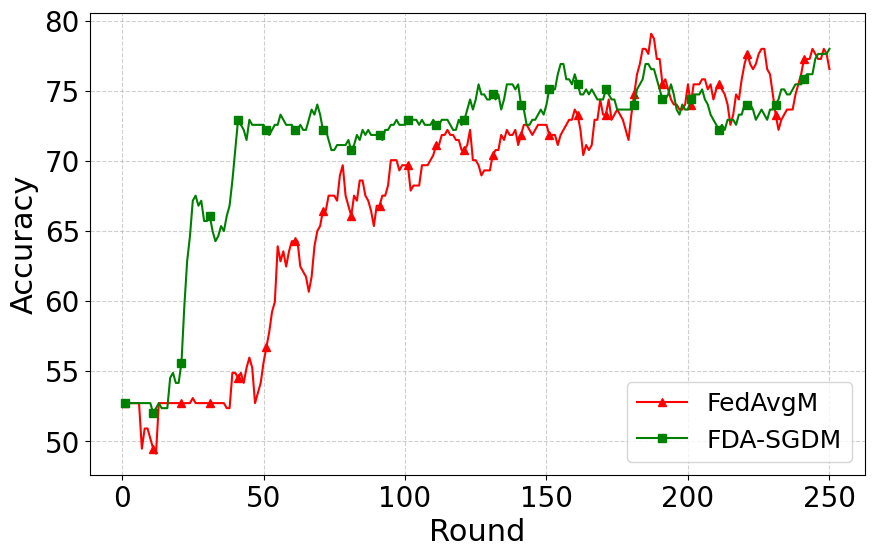

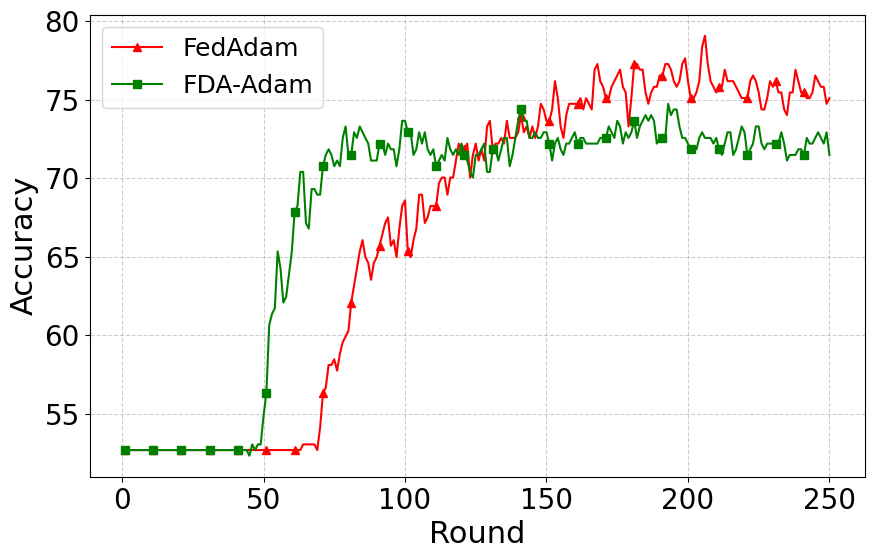

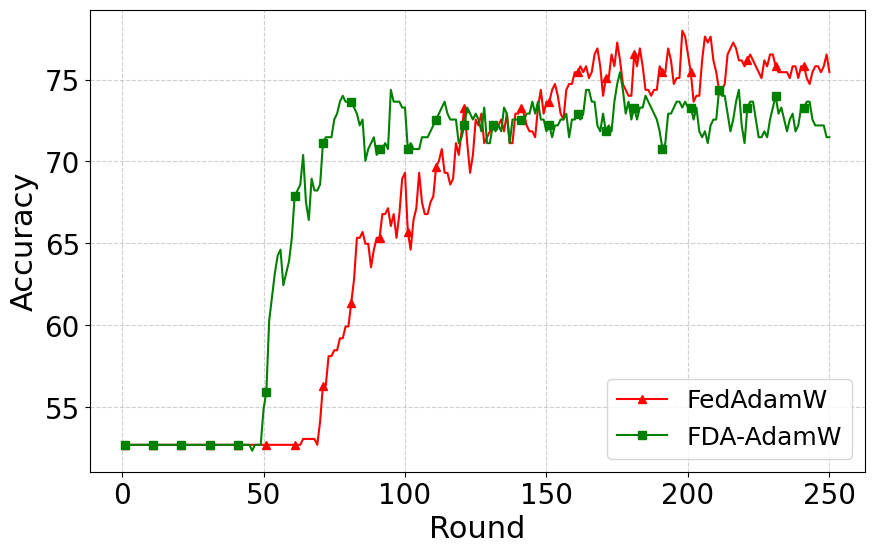

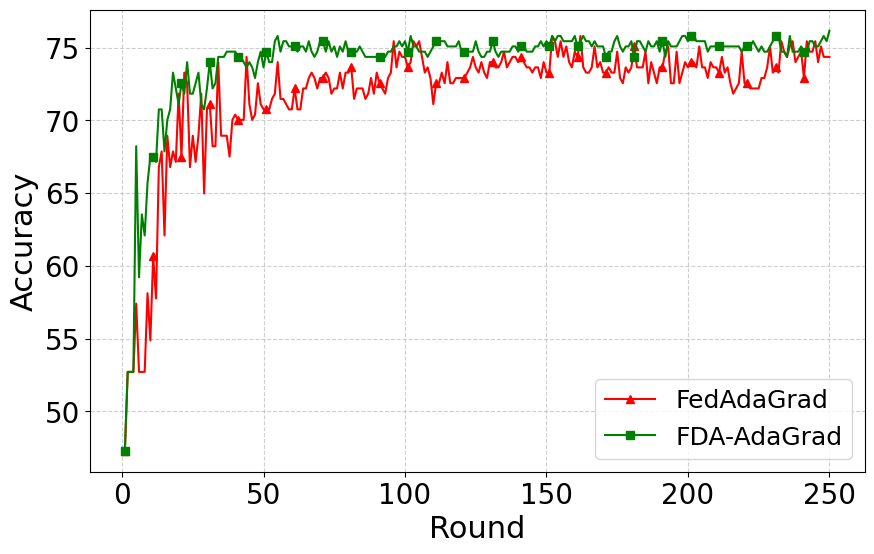

In [483]:
accuracy(df_fda_opt, df_fed_opt, 'RTE', every=10)

### Variance

In [88]:
plot_all_variance(df_fed_opt, 'RTE')

### Best learning rate for FedOpt

In [46]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'RTE', 'Accuracy')

In [47]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'RTE', 'Accuracy',)

In [48]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'RTE', 'Accuracy',)

In [49]:
#learning_rate_grid(df_mrpc, 'FedAdaGrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'RTE', 'Accuracy',)

In [50]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'RTE', 'Accuracy',)

### FDA vs Fed-Opt

In [147]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [149]:
percentages = [0.85, 0.9, 0.95]

In [150]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('RTE', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('RTE', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('RTE', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('RTE', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    for e in sorted(df_fed_alg['E'].unique()):
    #for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

Algorithm 0.85  0.9 0.95
0        FedAvg (e = 1)   50   67  103
1        FedAvg (e = 5)   12   16   20
2       FedAvg (e = 10)    7   10   23
3               FDA-SGD   13   16   20
4                     #    #    #    #
5       FedAvgM (e = 1)   73  111  182
6       FedAvgM (e = 5)   29   45  102
7      FedAvgM (e = 10)   17   27   70
8              FDA-SGDM   25   41  126
9                     #    #    #    #
10      FedAdam (e = 1)   93  118  153
11      FedAdam (e = 5)   49   68  176
12     FedAdam (e = 10)   45   55  103
13             FDA-Adam   61   72  188
14                    #    #    #    #
15     FedAdamW (e = 1)   94  118  160
16     FedAdamW (e = 5)   49   67  101
17    FedAdamW (e = 10)   45   61  106
18            FDA-AdamW   61   71  176
19                    #    #    #    #
20   FedAdaGrad (e = 1)   14   20   96
21   FedAdaGrad (e = 5)    8   16   52
22  FedAdaGrad (e = 10)    6   12   22
23          FDA-Adagrad    5   18   54
24                    #    #    #    #

In [24]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [25]:
speedup_tab

Information      0.85       0.9      0.95
0      FDA-SGD Speedup  3.846154    4.1875      5.15
1     FDA-SGDM Speedup      2.92  2.707317  1.444444
2     FDA-Adam Speedup   1.52459  1.638889   0.81383
3    FDA-AdamW Speedup  1.540984  1.661972  0.909091
4  FDA-Adagrad Speedup       2.8  1.111111  1.777778
5      Average Speedup  2.526346  2.261358  2.019029

## CoLa

clients = 50, per round = 5, max rounds = 1000

In [51]:
best_matthews_correlation = 63.6

In [52]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='cola', alpha=1., batch_size=8, num_clients=50, clients_per_round=5, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='cola', alpha=1., batch_size=8, num_clients=50, clients_per_round=5, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 850]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 850]

In [53]:
max(df_fed_opt['matthews_correlation'])

67.09

In [54]:
max(df_fda_opt['matthews_correlation'])

64.56

### Training Loss

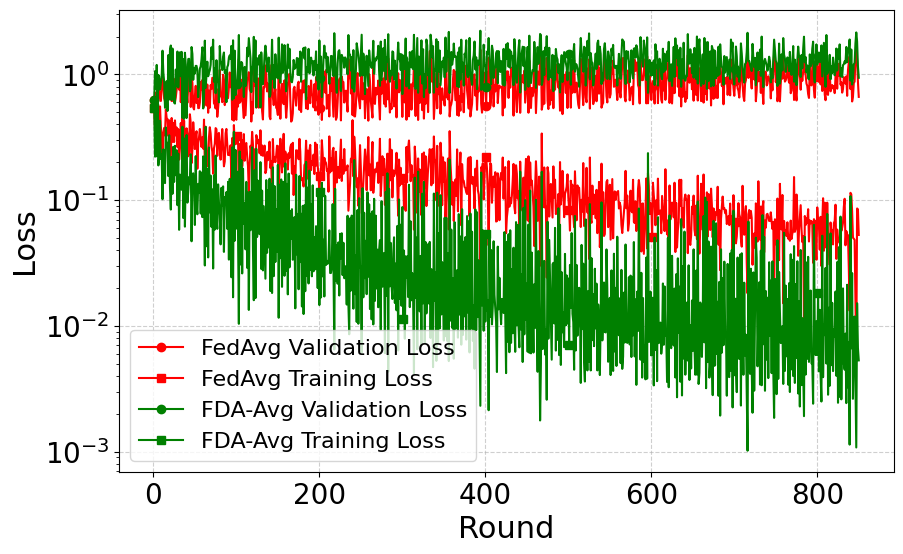

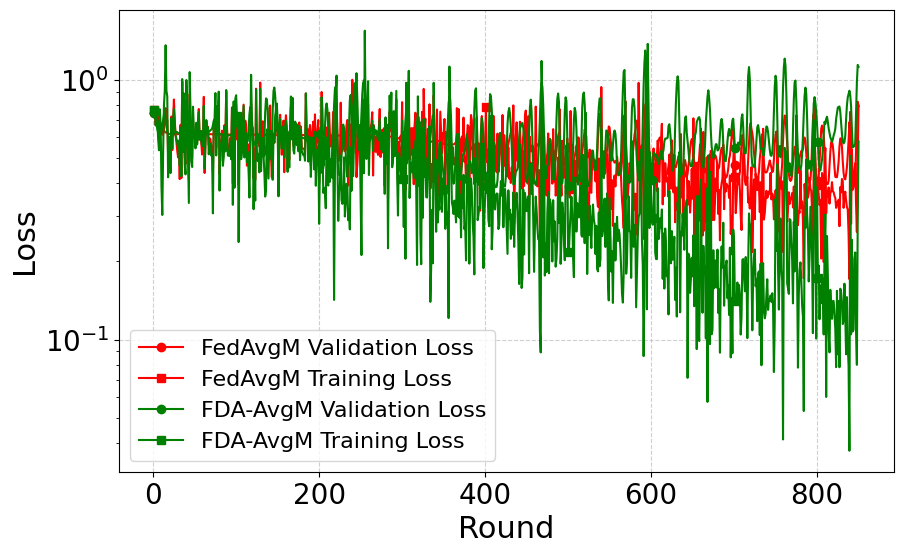

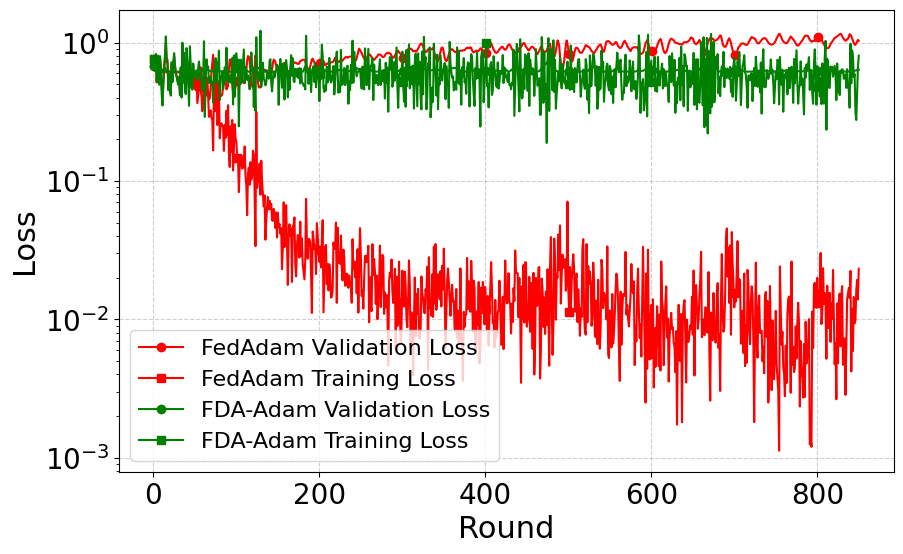

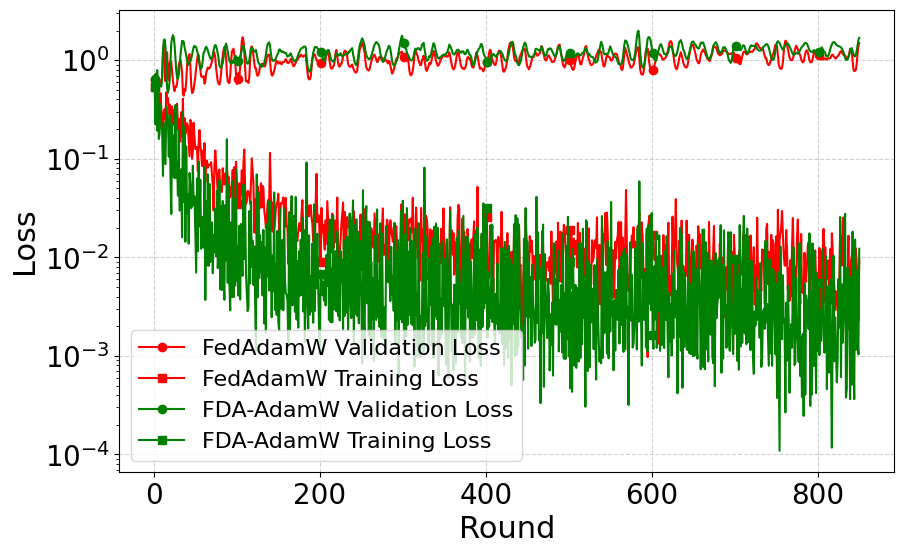

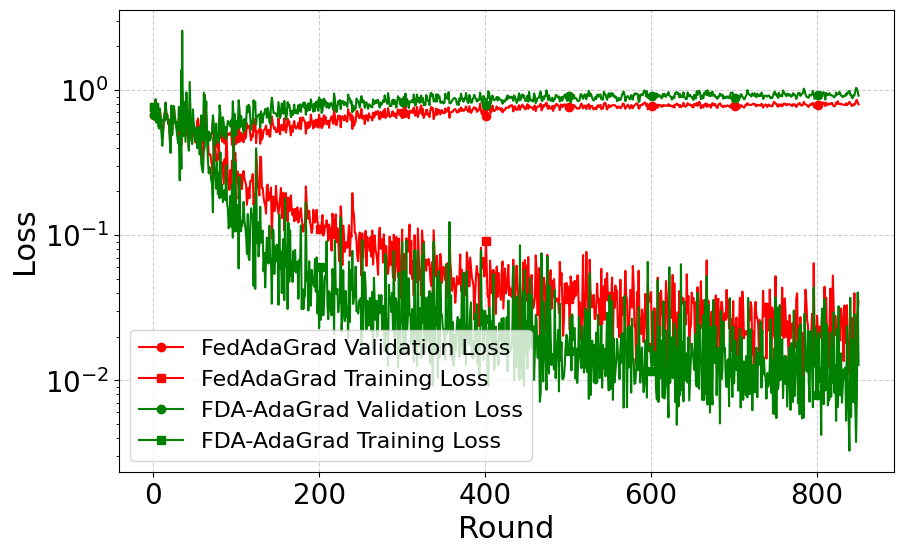

In [228]:
training_loss(df_fda_opt, df_fed_opt, 'CoLA', every=100)

### Best learning rate for FedOpt

In [55]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'CoLA', 'Matthews Correlation')

In [56]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'CoLA', 'Matthews Correlation',)

In [57]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'CoLA', 'Matthews Correlation',)

In [58]:
#learning_rate_grid(df_mrpc, 'FedAdaGrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'CoLA', 'Matthews Correlation',)

In [59]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'CoLA', 'Matthews Correlation',)

### Variance

In [95]:
plot_all_variance(df_fed_opt, 'CoLA', every=100)

### FDA vs Fed-Opt

In [134]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [151]:
percentages = [0.85, 0.9, 0.95]

In [152]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('CoLA', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('CoLA', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('CoLA', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('CoLA', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            matthews_correlation = perc * best_matthews_correlation
            
            def_fed_alg_best = df_e[df_e['matthews_correlation'] >= matthews_correlation]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        matthews_correlation = perc * best_matthews_correlation
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['matthews_correlation'] >= matthews_correlation]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']

table

In [154]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [156]:
table

Algorithm 0.85  0.9 0.95
0       FedAvg (e = 1)  166  203  775
1              FDA-SGD   35  203  559
2                    #    #    #    #
3      FedAvgM (e = 1)  542  602  812
4             FDA-SGDM  214  234  401
5                    #    #    #    #
6      FedAdam (e = 1)   55   67   67
7             FDA-Adam  NaN  NaN  NaN
8                    #    #    #    #
9     FedAdamW (e = 1)   36   77  243
10           FDA-AdamW   55   57  129
11                   #    #    #    #
12  FedAdaGrad (e = 1)   52   73   77
13         FDA-Adagrad   54   54  NaN
14                   #    #    #    #

In [157]:
speedup_tab

Information      0.85       0.9      0.95
0      FDA-SGD Speedup  4.742857       1.0  1.386404
1     FDA-SGDM Speedup   2.53271   2.57265  2.024938
2     FDA-Adam Speedup       NaN       NaN       NaN
3    FDA-AdamW Speedup  0.654545  1.350877  1.883721
4  FDA-Adagrad Speedup  0.962963  1.351852       NaN
5      Average Speedup  2.223269  1.568845  1.765021

## SST-2

clients = 100, per round = 10, max rounds = 200

In [21]:
best_accuracy = 94.8

In [22]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='sst2', alpha=1., batch_size=8, num_clients=100, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='sst2', alpha=1., batch_size=8, num_clients=100, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

In [23]:
max(df_fed_opt['accuracy'])

95.3

In [24]:
max(df_fda_opt['accuracy'])

95.07

### Training Loss

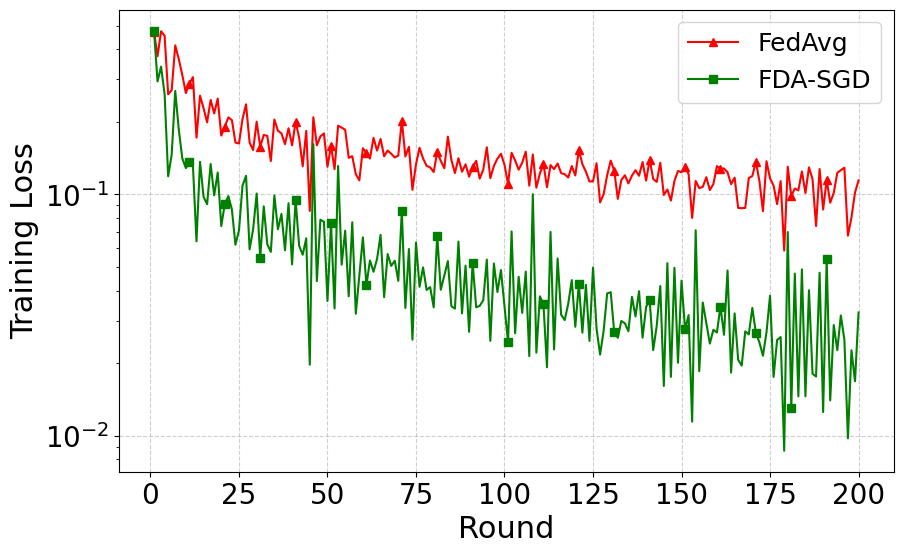

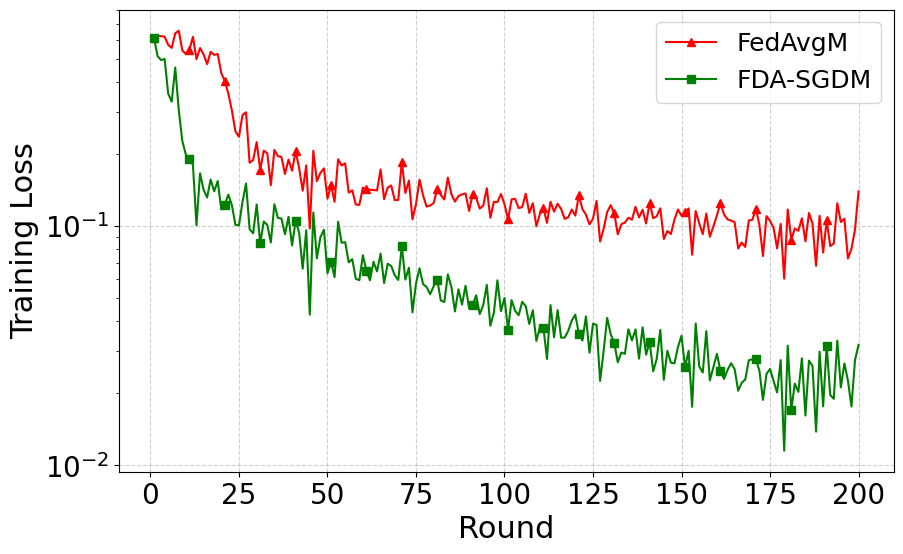

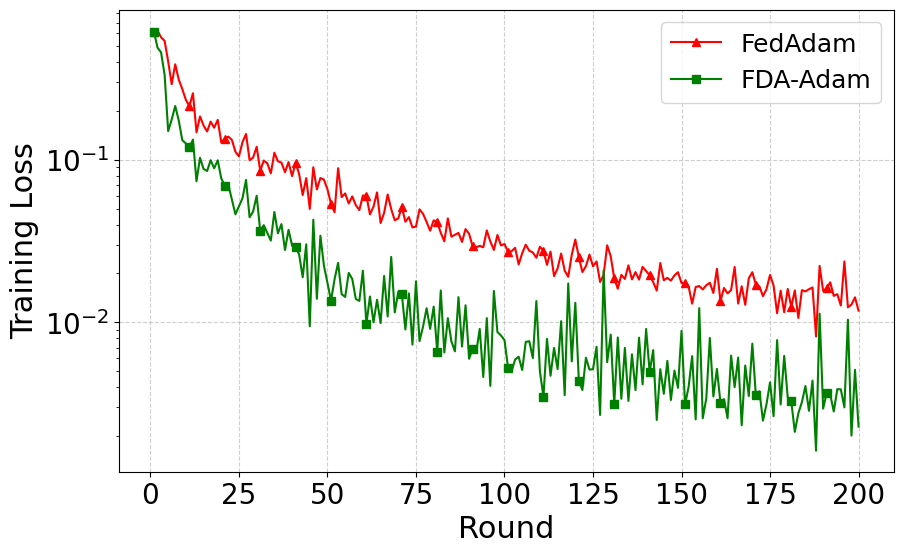

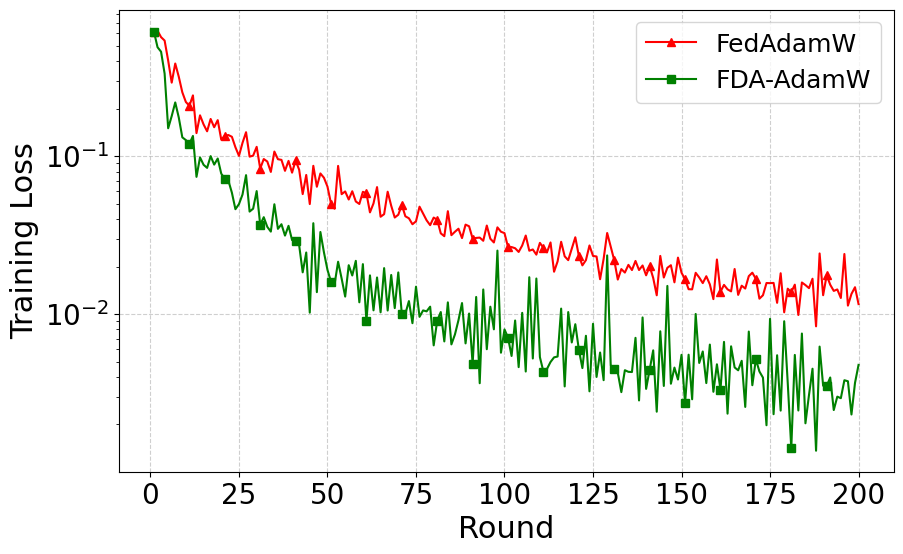

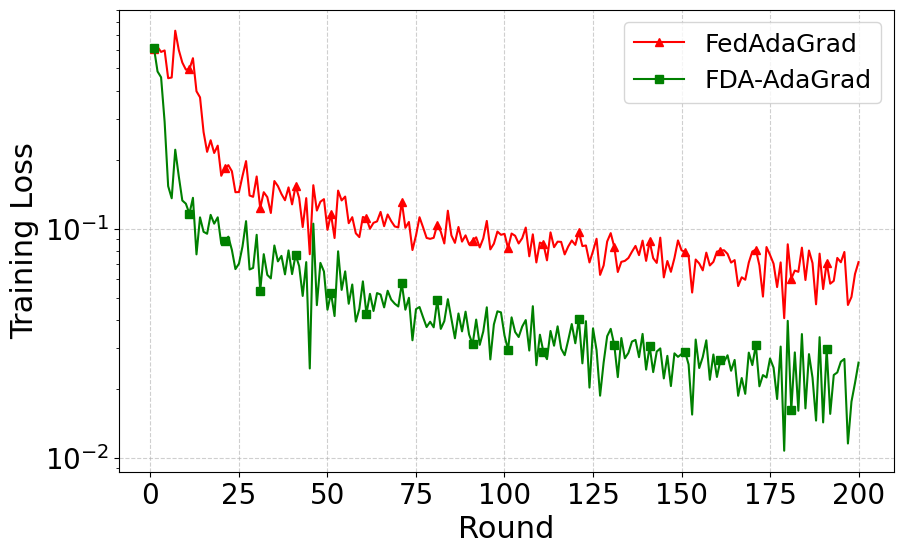

In [148]:
training_loss(df_fda_opt, df_fed_opt, 'SST-2', every=10)

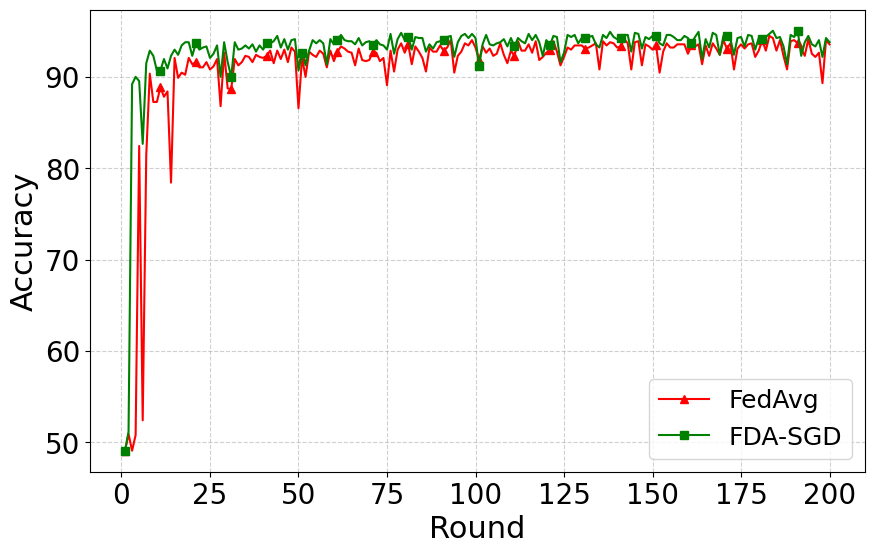

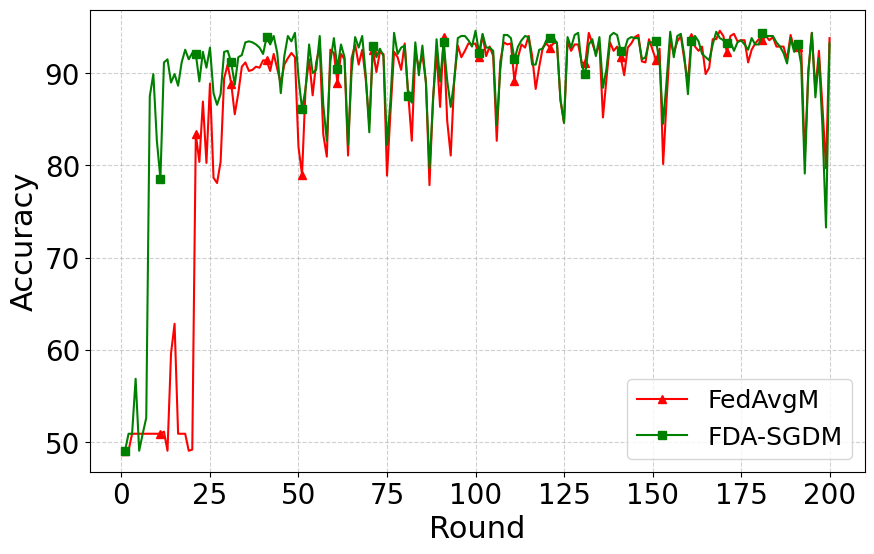

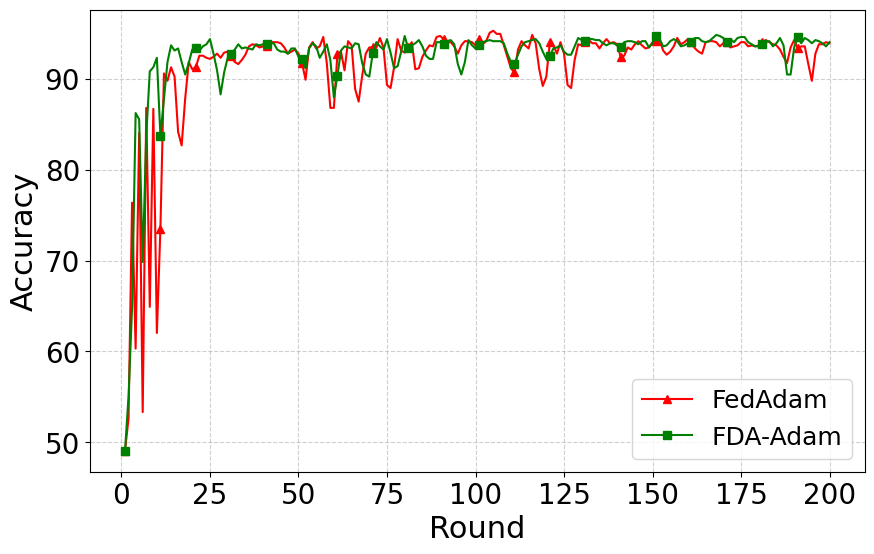

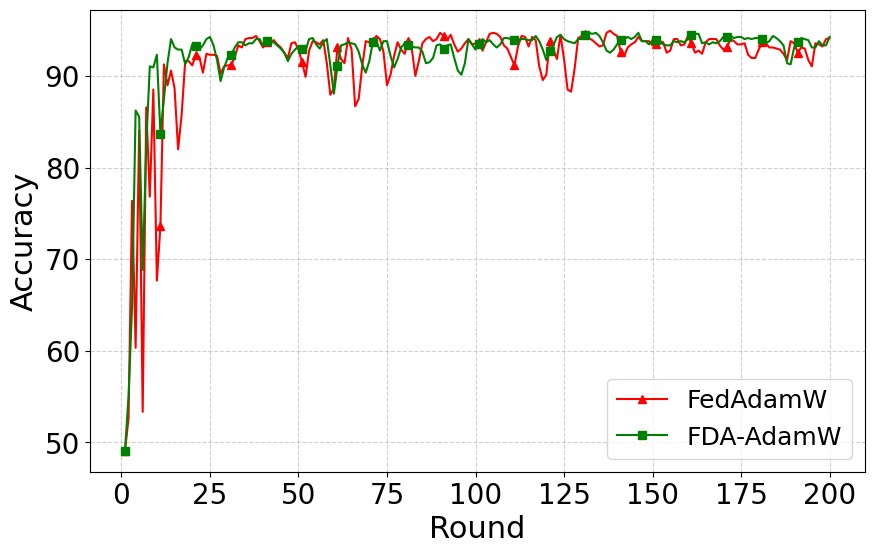

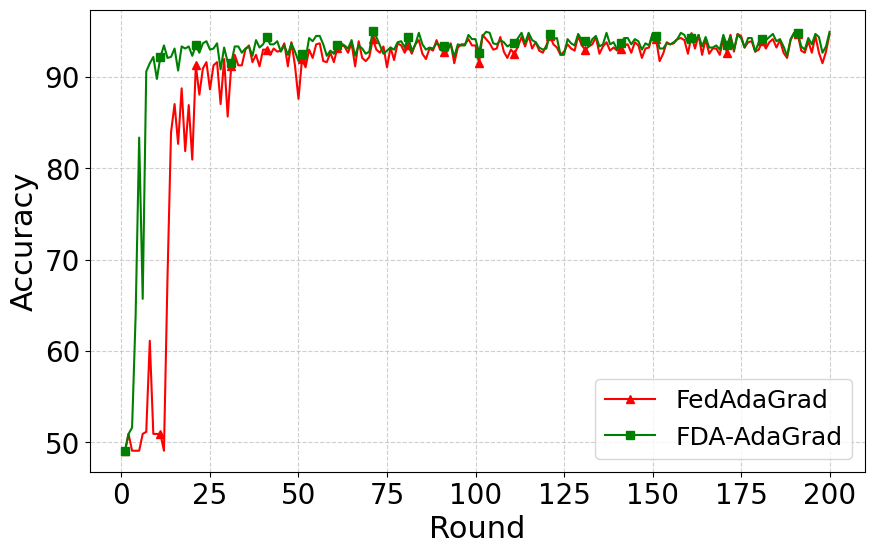

In [493]:
accuracy(df_fda_opt, df_fed_opt, 'SST-2', every=10)

### Paper training loss

In [156]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'SST-2'
every = 40

markersize=8
    
pdf = PdfPages(f'plots/train_loss_{ds_name}.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 10), sharex=True, sharey=True)


# --------------- FedAvg ------------------------------------
i = 0
alg = 'FedAvg'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

ax.set_title(ds_name, fontsize=26)

# --------------- FedAvgM ------------------------------------
i = 1
alg = 'FedAvgM'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')


# --------------- FedAdam ------------------------------------
i = 2
alg = 'FedAdam'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdamW ------------------------------------
i = 3
alg = 'FedAdamW'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdaGrad ------------------------------------
i = 4
alg = 'FedAdaGrad'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

plt.subplots_adjust(left=0.25, top=0.96, bottom=0.07, right=0.95)



# Label the axes
plt.xlabel('Round')
#plt.ylabel('Training Loss')

# Adjust layout to save space
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust spacing

pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()
#plt.show()

### Best learning rate for FedOpt

In [65]:
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'SST-2', 'Accuracy')

In [66]:
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'SST-2', 'Accuracy',)

In [67]:
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'SST-2', 'Accuracy',)

In [68]:
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'SST-2', 'Accuracy',)

In [69]:
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'SST-2', 'Accuracy',)

### Variance

In [372]:
plot_all_variance(df_fed_opt, 'SST-2', every=20)

### FDA vs Fed-Opt

In [110]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [171]:
percentages = [0.1, 0.9, 0.95, 0.99]

In [172]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    for e in sorted(df_fed_alg['E'].unique()):
    #for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

Algorithm 0.1 0.9 0.95 0.99
0       FedAvg (e = 1)   1   8    8   93
1       FedAvg (e = 5)   1   3    4   39
2              FDA-SGD   1   3    7   43
3                    #   #   #    #    #
4      FedAvgM (e = 1)   1  23   30   91
5      FedAvgM (e = 5)   1   8    8   83
6     FedAvgM (e = 10)   1   4    8   25
7             FDA-SGDM   1   8   12   41
8                    #   #   #    #    #
9      FedAdam (e = 1)   1   7   12   42
10     FedAdam (e = 5)   1   4    8   25
11    FedAdam (e = 10)   1   4    5   23
12            FDA-Adam   1   4    8   25
13                   #   #   #    #    #
14    FedAdamW (e = 1)   1   7   12   35
15    FedAdamW (e = 5)   1   4    8   25
16   FedAdamW (e = 10)   1   4    5   25
17           FDA-AdamW   1   4    8   14
18                   #   #   #    #    #
19  FedAdaGrad (e = 1)   1  15   21   67
20  FedAdaGrad (e = 5)   1   5    7   41
21         FDA-Adagrad   1   7    7   24
22                   #   #   #    #    #

In [174]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [175]:
table

Algorithm 0.9 0.95 0.99
0       FedAvg (e = 1)   8    8   93
1              FDA-SGD   3    7   43
2                    #   #    #    #
3      FedAvgM (e = 1)  23   30   91
4             FDA-SGDM   8   12   41
5                    #   #    #    #
6      FedAdam (e = 1)   7   12   42
7             FDA-Adam   4    8   25
8                    #   #    #    #
9     FedAdamW (e = 1)   7   12   35
10           FDA-AdamW   4    8   14
11                   #   #    #    #
12  FedAdaGrad (e = 1)  15   21   67
13         FDA-Adagrad   7    7   24
14                   #   #    #    #

In [176]:
speedup_tab

Information       0.9      0.95      0.99
0      FDA-SGD Speedup  2.666667  1.142857  2.162791
1     FDA-SGDM Speedup     2.875       2.5  2.219512
2     FDA-Adam Speedup      1.75       1.5      1.68
3    FDA-AdamW Speedup      1.75       1.5       2.5
4  FDA-Adagrad Speedup  2.142857       3.0  2.791667
5      Average Speedup  2.236905  1.928571  2.270794

### FDA vs Fed-Opt for 95% accuracy with varying E

In [27]:
for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:
    
    plt.figure(figsize=(5, 3.5))
    
    pdf = PdfPages(f'plots/SST2_{alg}_E.pdf')

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]
    
    fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_R = []
    
    fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_R = []
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:
        
        df_e = df_fed_alg[df_fed_alg['E'] == E]
        
        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * 0.99]
        
        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])
    
    for E in fdaopt_E:
        
        df_e = df_fda_alg[df_fda_alg['E'] == E]
        
        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * 0.99]
        
        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])
    
    
    #plt.plot(fedopt_E, fedopt_R, marker='^', linestyle='-', label=alg, color='red')
    
    fda_alg = alg.replace('Fed', 'FDA-')
    fda_alg = fda_alg.replace('AvgM', 'SGDM')
    fda_alg = fda_alg.replace('Avg', 'SGD')
    #plt.plot(fdaopt_E, fdaopt_R, marker='s', linestyle='-', label=fda_alg, color='green')
    
    
    fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]

    plt.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    plt.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')
    
    if fedopt_interpolated_indices:
        plt.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    
    plt.ylabel('Rounds')
    plt.xlabel('Local Epoch (E)')
    plt.xticks(fdaopt_E)
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.ylim([0, 100])
    plt.legend()
    
    plt.subplots_adjust(left=0.2, top=0.96, bottom=0.25, right=0.97)
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

### Paper Varying E

In [25]:
total_fedopt = 0
total_fdaopt = 0

In [26]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'SST-2'
close = 0.99
    
pdf = PdfPages(f'plots/{ds_name}_E.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 11), sharex=True)


# --------------- FedAvg ------------------------------------

for i, (alg, fda_alg) in enumerate(zip(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad'], ['FDA-SGD', 'FDA-SGDM', 'FDA-Adam', 'FDA-AdamW', 'FDA-AdaGrad'])):

    ax = axes[i]

    df_fed_alg = filter_opt(df_fed, alg)
    df_fda_alg = filter_opt(df_fda, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    #fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_E = [1, 3, 5, 15, 20]
    fdaopt_R = []

    #fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_E = [1, 3, 5, 15, 20] 
    fedopt_R = []

    #print(df_fed_alg['E'].unique())

    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:

        df_e = df_fed_alg[df_fed_alg['E'] == E]

        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])
            total_fedopt += def_fed_alg_best.iloc[0]['round']

    for E in fdaopt_E:

        df_e = df_fda_alg[df_fda_alg['E'] == E]

        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])
            total_fdaopt += def_fda_alg_best.iloc[0]['round']

    #fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit=1, method='linear', limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]
    
    # Create interpolation function using only valid values
    interp_func = interp1d(fedopt_E_clean, fedopt_R_clean, kind='linear', fill_value='extrapolate')
    # Perform interpolation for all x values
    fedopt_R_interpolated = interp_func(fedopt_E)

    ax.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    ax.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')

    if fedopt_interpolated_indices:
        ax.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    ax.set_ylabel('Rounds')
    ax.set_xticks(fdaopt_E)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    #ax.set_ylim([0, 100])
    if alg == 'FedAvgM':
        ax.set_ylim([20, 99])
        ax.legend(fontsize=16.5)
    if alg == 'FedAdamW':
        ax.legend(loc='upper center')
        ax.set_ylim([10, 55])
    if alg == 'FedAdaGrad':
        ax.legend(loc='upper center')
        ax.set_ylim([10, 90])

    if i == 0:
        ax.set_title(ds_name, fontsize=26)




plt.xlabel('Local Epochs (E)')

#plt.show()
plt.subplots_adjust(left=0.2, top=0.95, bottom=0.07, right=0.95)


pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()
#plt.show()

In [46]:
total_fdaopt

680

In [47]:
total_fedopt / total_fdaopt

1.463235294117647

## QNLI

clients = 250, per round = 10, max rounds = 200

In [70]:
best_accuracy = 92.8

In [71]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='qnli', alpha=1., batch_size=8, num_clients=250, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='qnli', alpha=1., batch_size=8, num_clients=250, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

In [72]:
max(df_fed_opt['accuracy'])

92.17999999999999

In [73]:
max(df_fda_opt['accuracy'])

91.95

### Training Loss

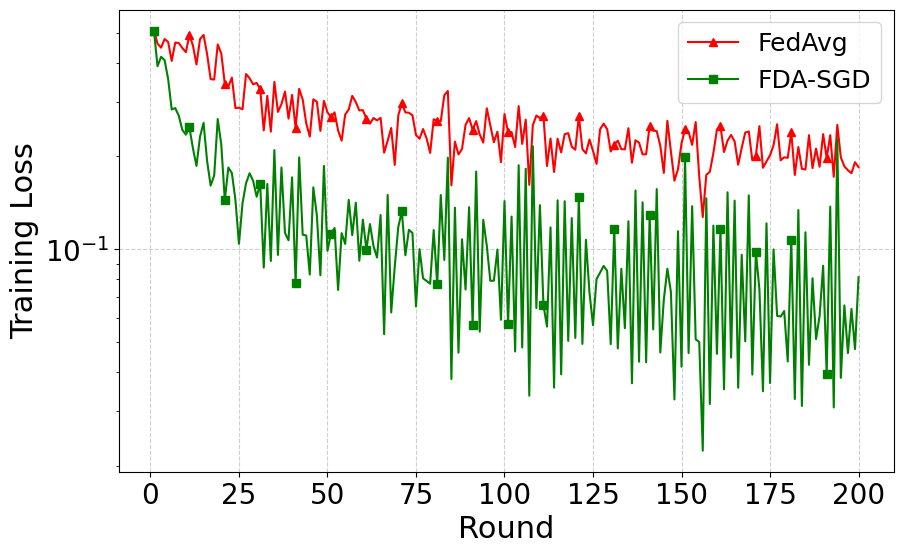

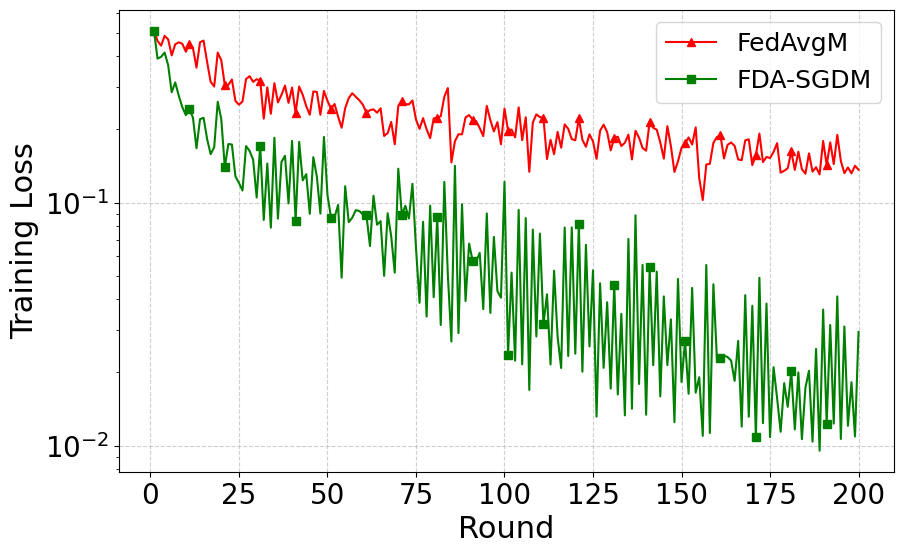

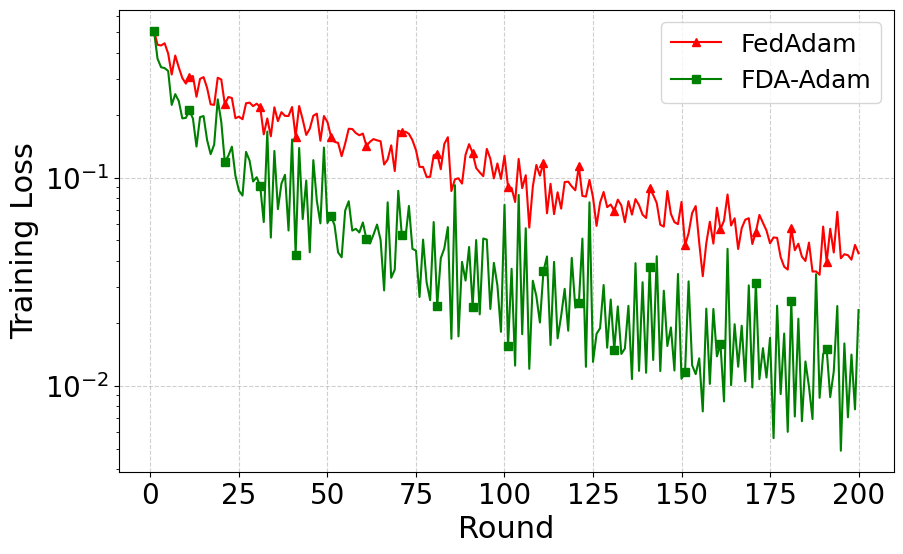

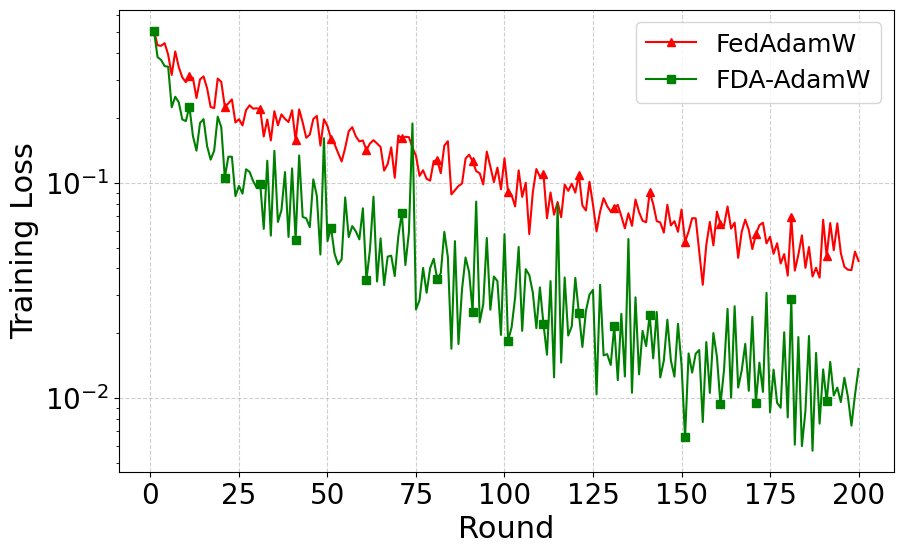

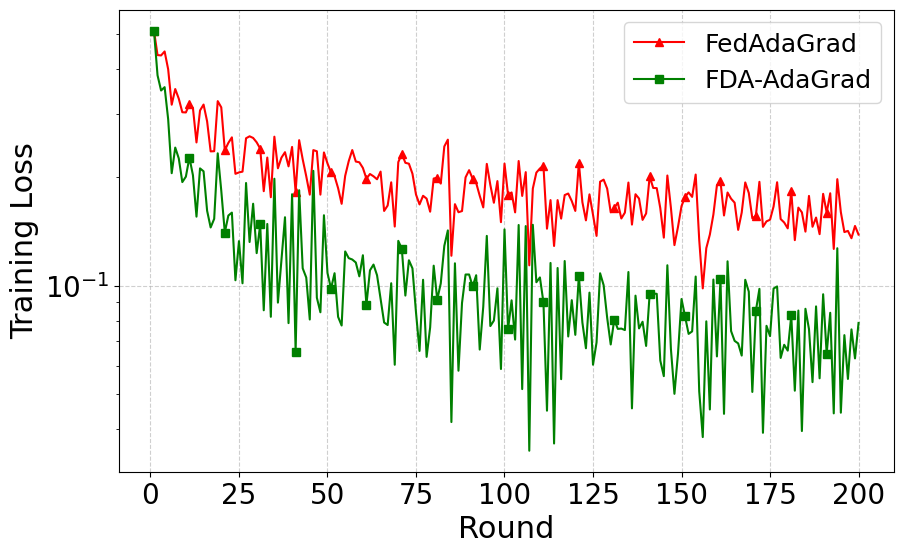

In [385]:
training_loss(df_fda_opt, df_fed_opt, 'QNLI', every=10)

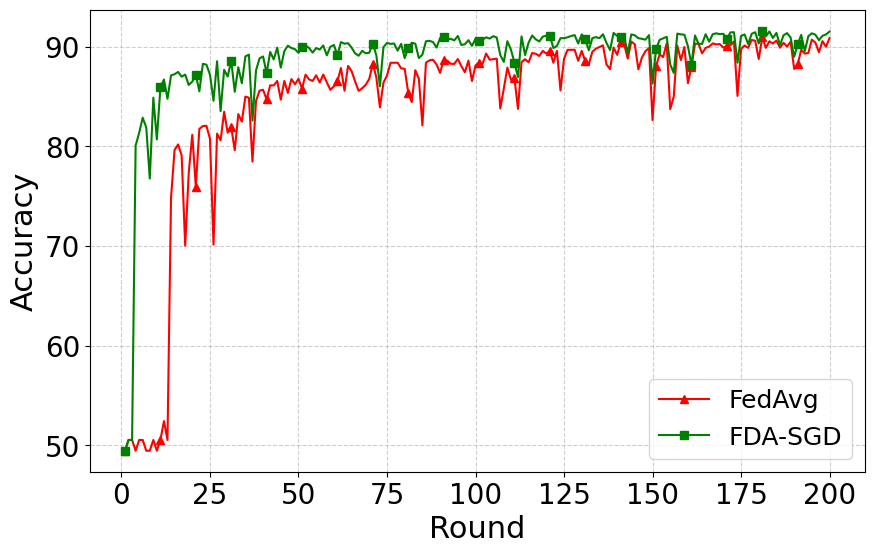

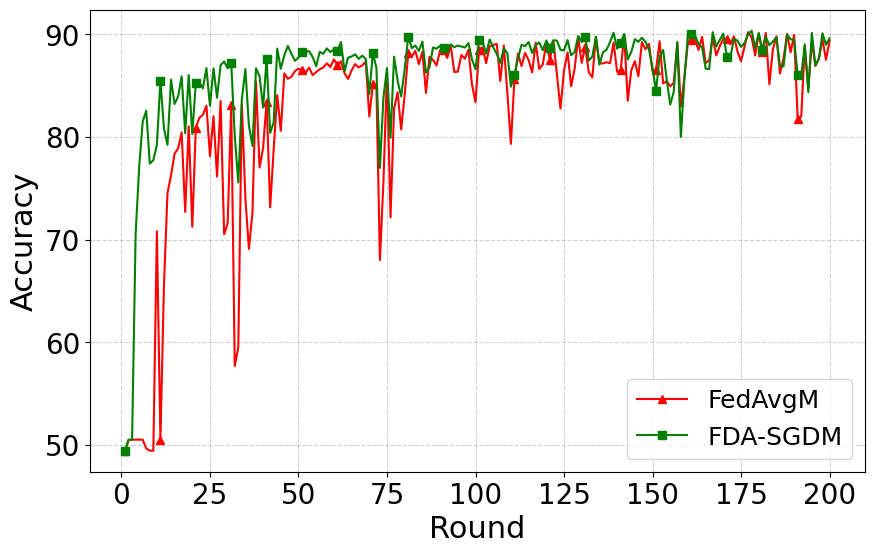

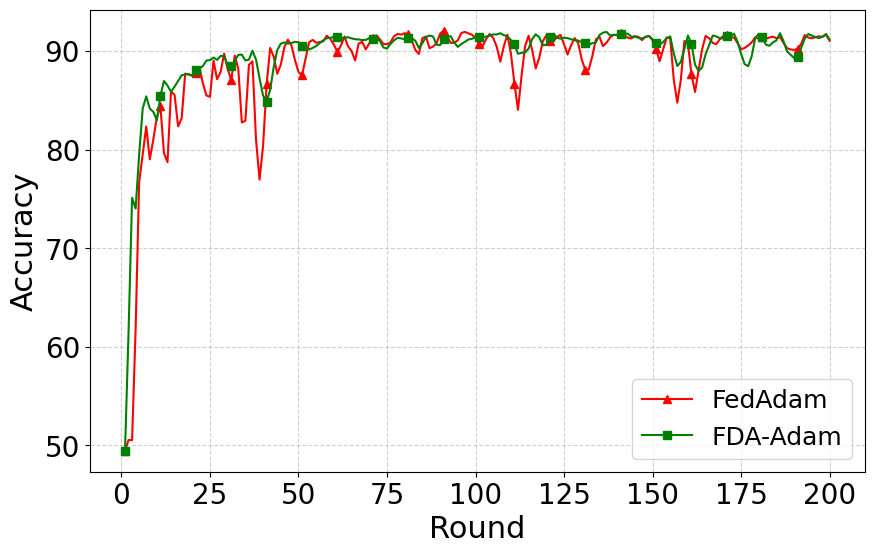

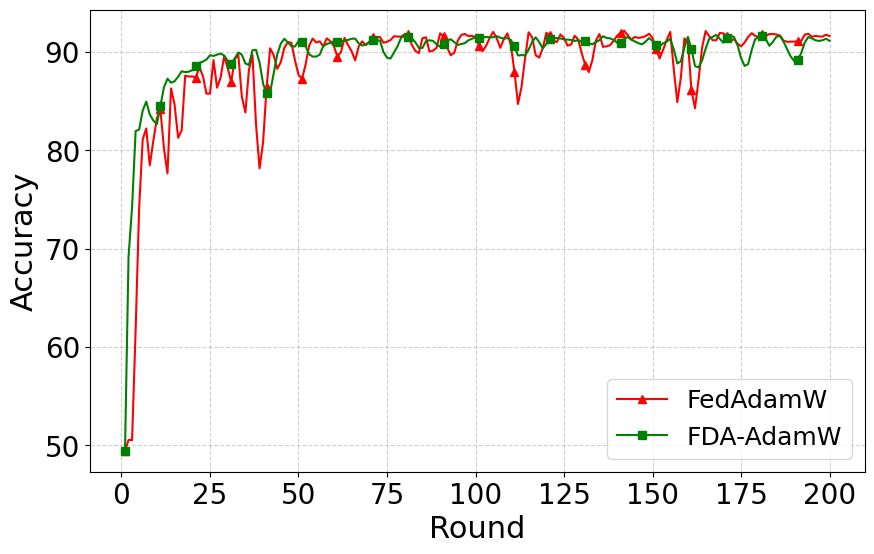

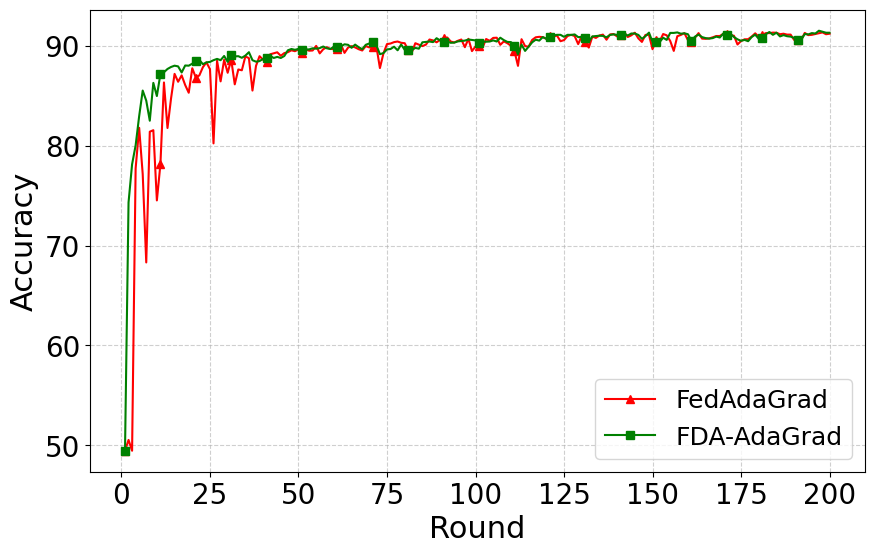

In [498]:
accuracy(df_fda_opt, df_fed_opt, 'QNLI', every=10)

### Best learning rate for FedOpt

In [74]:
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'QNLI', 'Accuracy')

In [75]:
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'QNLI', 'Accuracy',)

In [76]:
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'QNLI', 'Accuracy',)

In [77]:
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'QNLI', 'Accuracy',)

In [78]:
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'QNLI', 'Accuracy',)

### Variance

In [9]:
plot_all_variance(df_fed_opt, 'QNLI', every=20)

NameError: name 'plot_all_variance' is not defined

### FDA vs Fed-Opt

In [181]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [162]:
percentages = [0.85, 0.9, 0.95]

In [164]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('QNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('QNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('QNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('QNLI', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']

table

Algorithm 0.85 0.9 0.95
0       FedAvg (e = 1)   15  35   71
1              FDA-SGD    4   9   23
2                    #    #   #    #
3      FedAvgM (e = 1)   16  38   81
4             FDA-SGDM    6  11   44
5                    #    #   #    #
6      FedAdam (e = 1)    6  11   22
7             FDA-Adam    5   6   22
8                    #    #   #    #
9     FedAdamW (e = 1)    6  11   22
10           FDA-AdamW    4   6   20
11                   #    #   #    #
12  FedAdaGrad (e = 1)    5  12   24
13         FDA-Adagrad    4   6   20
14                   #    #   #    #

In [184]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [185]:
table

Algorithm 0.85 0.9 0.95
0       FedAvg (e = 1)   15  35   71
1              FDA-SGD    4   9   23
2                    #    #   #    #
3      FedAvgM (e = 1)   16  38   81
4             FDA-SGDM    6  11   44
5                    #    #   #    #
6      FedAdam (e = 1)    6  11   22
7             FDA-Adam    5   6   22
8                    #    #   #    #
9     FedAdamW (e = 1)    6  11   22
10           FDA-AdamW    4   6   20
11                   #    #   #    #
12  FedAdaGrad (e = 1)    5  12   24
13         FDA-Adagrad    4   6   20
14                   #    #   #    #

In [186]:
speedup_tab

Information      0.85       0.9      0.95
0      FDA-SGD Speedup      3.75  3.888889  3.086957
1     FDA-SGDM Speedup  2.666667  3.454545  1.840909
2     FDA-Adam Speedup       1.2  1.833333       1.0
3    FDA-AdamW Speedup       1.5  1.833333       1.1
4  FDA-Adagrad Speedup      1.25       2.0       1.2
5      Average Speedup  2.073333   2.60202  1.645573

# DeBERTa-v3

In [23]:
df_fedopt = df_fedopt_tmp[df_fedopt_tmp['checkpoint'] == 'microsoft/deberta-v3-base']
df_fdaopt = df_fdaopt_tmp[df_fdaopt_tmp['checkpoint'] == 'microsoft/deberta-v3-base']

## MNLI-m

clients = 1000, per round = 10, max rounds = 100

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name Adam --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-2 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name AdamW --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-4 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name Adagrad --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-2 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name SGD --client_opt_name SGD --server_opt_args lr=1.0 momentum=0.9 --client_opt_args lr=1e-3 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name SGD --client_opt_name SGD --server_opt_args lr=1.0 --client_opt_args lr=1e-2 --fda --threshold

In [24]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

best_accuracy = 90.6

### Best learning rate for FedOpt

In [25]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'MRPC', 'Accuracy_m')

In [26]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'MRPC', 'Accuracy_m',)

In [27]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'MRPC', 'Accuracy_m',)

In [28]:
#learning_rate_grid(df_mrpc, 'FedAdaGrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'MRPC', 'Accuracy_m',)

In [29]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'MRPC', 'Accuracy_m',)

### FDA vs Fed-Opt

In [30]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [31]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy_m'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy_m'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

Algorithm 0.8 0.85 0.9  0.91  0.92  0.93  0.94  0.95  0.96  0.97  \
0       FedAvg (e = 1)  12   12  16  16.0  18.0  20.0  22.0  24.0  35.0  52.0   
1              FDA-SGD   4    4   8   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2                    #   #    #   #     #     #     #     #     #     #     #   
3      FedAvgM (e = 1)  29   29  35    36    42    42    42    51    69    71   
4             FDA-SGDM  12   12  15    15    22    22    37    37    45    55   
5                    #   #    #   #     #     #     #     #     #     #     #   
6      FedAdam (e = 1)  10   11  12    13    17    18    19    25    31    50   
7             FDA-Adam   9    9  10    11    11    13    15    24    34    49   
8                    #   #    #   #     #     #     #     #     #     #     #   
9     FedAdamW (e = 1)  56   57  66    72    72    76    76    82    91   107   
10           FDA-AdamW  40   43  54    55    62    69    71    89    96   NaN   
11                   #   #    #   #     #     #     #     #     #     #     #   
12  FedAdaGrad (e = 1)   7    8  15    16    18    21    26    38    55   117   
13         FDA-Adagrad   6   14  15    17    23    29    37    45    56   NaN   
14                   #   #    #   #     #     #     #     #     #     #     #   

    0.98 0.99    1  
0   90.0  NaN  NaN  
1    NaN  NaN  NaN  
2      #    #    #  
3    127  193  NaN  
4    NaN  NaN  NaN  
5      #    #    #  
6     86  171  NaN  
7     58  NaN  NaN  
8      #    #    #  
9    129  187  NaN  
10   NaN  NaN  NaN  
11     #    #    #  
12   NaN  NaN  NaN  
13   NaN  NaN  NaN  
14     #    #    #

In [32]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [33]:
speedup_tab

Information       0.8      0.85       0.9      0.91      0.92  \
0      FDA-SGD Speedup       3.0       3.0       2.0       NaN       NaN   
1     FDA-SGDM Speedup  2.416667  2.416667  2.333333       2.4  1.909091   
2     FDA-Adam Speedup  1.111111  1.222222       1.2  1.181818  1.545455   
3    FDA-AdamW Speedup       1.4  1.325581  1.222222  1.309091   1.16129   
4  FDA-Adagrad Speedup  1.166667  0.571429       1.0  0.941176  0.782609   
5      Average Speedup  1.818889   1.70718  1.551111  1.458021  1.349611   

       0.93      0.94      0.95      0.96      0.97      0.98 0.99    1  
0       NaN       NaN       NaN       NaN       NaN       NaN  NaN  NaN  
1  1.909091  1.135135  1.378378  1.533333  1.290909       NaN  NaN  NaN  
2  1.384615  1.266667  1.041667  0.911765  1.020408  1.482759  NaN  NaN  
3  1.101449  1.070423  0.921348  0.947917       NaN       NaN  NaN  NaN  
4  0.724138  0.702703  0.844444  0.982143       NaN       NaN  NaN  NaN  
5  1.279823  1.043732  1.046459  1.093789  1.155659  1.482759  NaN  NaN

## MNLI-mm

clients = 1000, per round = 10, max rounds = 100

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name Adam --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-2 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name AdamW --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-4 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name Adagrad --client_opt_name SGD --server_opt_args lr=1e-4 --client_opt_args lr=1e-2 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name SGD --client_opt_name SGD --server_opt_args lr=1.0 momentum=0.9 --client_opt_args lr=1e-3 --fda --threshold

python -m fdaopt.miscellaneous.create_hyperparameters --checkpoint microsoft/deberta-v3-base --total_rounds 100 --ds_name mnli --num_labels 3 --num_clients 1000 --clients_per_round 10 --server_opt_name SGD --client_opt_name SGD --server_opt_args lr=1.0 --client_opt_args lr=1e-2 --fda --threshold

In [34]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

best_accuracy = 90.7

### Best learning rate for FedOpt

In [35]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvgM', 'MRPC', 'Accuracy_mm')

In [36]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdam', 'MRPC', 'Accuracy_mm',)

In [37]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdamW', 'MRPC', 'Accuracy_mm',)

In [38]:
#learning_rate_grid(df_mrpc, 'FedAdaGrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAdaGrad', 'MRPC', 'Accuracy_mm',)

In [39]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_fed_opt, 'FedAvg', 'MRPC', 'Accuracy_mm',)

### FDA vs Fed-Opt

In [40]:
percentages = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [41]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    for e in [1]:
        
        fed_opt_row = [f"{alg} (e = {e})"]
        
        df_e = df_fed_alg[df_fed_alg['E'] == e]
        
        #print(len(df_fed_alg))
        
        for perc in percentages:
            acc = perc * best_accuracy
            def_fed_alg_best = df_e[df_e['accuracy_mm'] >= acc]
            
            if def_fed_alg_best.empty:
                fed_opt_row.append(np.NaN)
            else:
                fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy_mm'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

Algorithm 0.8 0.85 0.9 0.91 0.92  0.93  0.94  0.95  0.96  0.97  \
0       FedAvg (e = 1)  12   12  15   16   16  18.0  20.0  22.0  31.0  39.0   
1              FDA-SGD   4    4   6    7    8   NaN   NaN   NaN   NaN   NaN   
2                    #   #    #   #    #    #     #     #     #     #     #   
3      FedAvgM (e = 1)  26   29  35   35   39    42    42    51    55    77   
4             FDA-SGDM  11   12  15   15   16    22    37    37    43    56   
5                    #   #    #   #    #    #     #     #     #     #     #   
6      FedAdam (e = 1)  10   11  12   13   17    18    19    19    25    48   
7             FDA-Adam   9    9  10   10   11    11    12    14    24    39   
8                    #   #    #   #    #    #     #     #     #     #     #   
9     FedAdamW (e = 1)  56   57  66   72   72    72    76    76    86    96   
10           FDA-AdamW  39   42  52   54   56    68    71    89    89   NaN   
11                   #   #    #   #    #    #     #     #     #     #     #   
12  FedAdaGrad (e = 1)   7    8  11   16   16    18    21    26    39    71   
13         FDA-Adagrad   6    6  14   14   17    22    24    37    48    85   
14                   #   #    #   #    #    #     #     #     #     #     #   

    0.98 0.99    1  
0   71.0  NaN  NaN  
1    NaN  NaN  NaN  
2      #    #    #  
3    104  NaN  NaN  
4    NaN  NaN  NaN  
5      #    #    #  
6     65  114  NaN  
7     52  NaN  NaN  
8      #    #    #  
9    113  166  NaN  
10   NaN  NaN  NaN  
11     #    #    #  
12   NaN  NaN  NaN  
13   NaN  NaN  NaN  
14     #    #    #

In [42]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [47]:
speedup_tab

Information       0.8      0.85       0.9      0.91      0.92  \
0      FDA-SGD Speedup       3.0       3.0       2.5  2.285714       2.0   
1     FDA-SGDM Speedup  2.363636  2.416667  2.333333  2.333333    2.4375   
2     FDA-Adam Speedup  1.111111  1.222222       1.2       1.3  1.545455   
3    FDA-AdamW Speedup  1.435897  1.357143  1.269231  1.333333  1.285714   
4  FDA-Adagrad Speedup  1.166667  1.333333  0.785714  1.142857  0.941176   
5      Average Speedup  1.815462  1.865873  1.617656  1.679048  1.641969   

       0.93      0.94      0.95      0.96      0.97  0.98 0.99    1  
0       NaN       NaN       NaN       NaN       NaN   NaN  NaN  NaN  
1  1.909091  1.135135  1.378378   1.27907     1.375   NaN  NaN  NaN  
2  1.636364  1.583333  1.357143  1.041667  1.230769  1.25  NaN  NaN  
3  1.058824  1.070423  0.853933  0.966292       NaN   NaN  NaN  NaN  
4  0.818182     0.875  0.702703    0.8125  0.835294   NaN  NaN  NaN  
5  1.355615  1.165973  1.073039  1.024882  1.147021  1.25  NaN  NaN